In [245]:
import xarray as xr
import os
import yaml
from datetime import datetime
import glob
import logging
import dask
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt
import json

In [246]:
ds = xr.open_dataset('data/merged_ds.nc').compute()

In [275]:
hurricane_tracks = json.load(open('hurricane_tracks.json'))

In [260]:
hurricane_names = list(hurricane_tracks.keys())

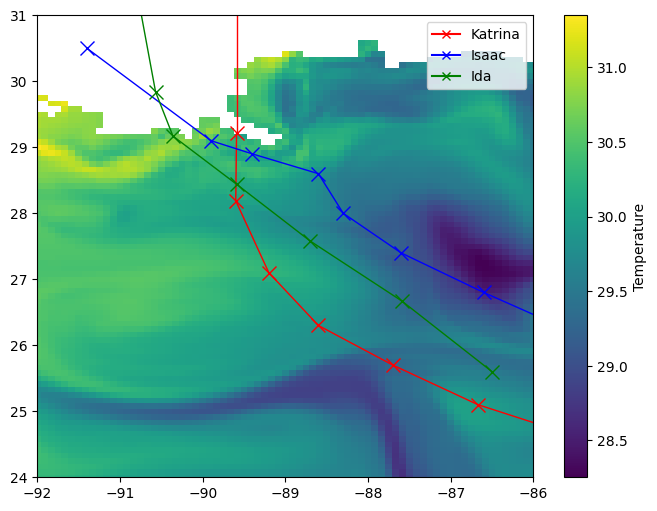

In [315]:
import numpy as np
import matplotlib.pyplot as plt

# Select the data for plotting
var = 'thetao'
temperature_data = ds.isel(time=28)[var].values
longitude = ds['longitude'].values
latitude = ds['latitude'].values

# Create a meshgrid for plotting
lon, lat = np.meshgrid(longitude, latitude)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the base temperature map
c = ax.pcolormesh(lon, lat, temperature_data, shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax, label=ds[var].attrs['long_name'])

# Set hard limits on plot extent
ax.set_xlim(longitude.min(), longitude.max())
ax.set_ylim(latitude.min(), latitude.max())

# Plot lines for all hurricanes and points for Katrina
colors = {'katrina': 'r', 'isaac': 'b', 'ida': 'g'}

# Plot lines and points for all hurricanes
for hurricane in hurricane_tracks.keys():
    points = hurricane_tracks[hurricane]['points']
    color = colors[hurricane]

    for i in range(len(points) - 1):
        curr_point = points[i]
        next_point = points[i + 1]

        curr_in_bounds = (longitude.min() <= curr_point['lon'] <= longitude.max() and 
                          latitude.min() <= curr_point['lat'] <= latitude.max())
        next_in_bounds = (longitude.min() <= next_point['lon'] <= longitude.max() and 
                          latitude.min() <= next_point['lat'] <= latitude.max())

        # Draw line if at least one point is in bounds
        if curr_in_bounds or next_in_bounds:
            ax.plot([curr_point['lon'], next_point['lon']], 
                    [curr_point['lat'], next_point['lat']], color=color, linestyle='-', linewidth=1)

        # Plot 'x' marker for current point if in bounds
        if curr_in_bounds:
            ax.plot(curr_point['lon'], curr_point['lat'], marker='x', color=color, markersize=10)

    # Also plot the final point if in bounds
    final_point = points[-1]
    if (longitude.min() <= final_point['lon'] <= longitude.max() and 
        latitude.min() <= final_point['lat'] <= latitude.max()):
        ax.plot(final_point['lon'], final_point['lat'], marker='x', color=color, markersize=10)

# Fix legend
legend_handles = [plt.Line2D([0], [0], color=color, marker='x', linestyle='-', label=name.capitalize())
                  for name, color in colors.items()]
ax.legend(handles=legend_handles, loc='upper right')



In [184]:
no_hurricane_years = [2006,2013,2015]
hurricane_years = [2005,2012,2021]

In [264]:
def get_latlon_within_radius(ds, hurricane_tracks, name, radius_deg):
    """
    Returns a list of (lat, lon) tuples from the dataset grid that fall within a 
    given radius (in degrees) of any hurricane point in the track.

    Parameters:
        ds (xr.Dataset): Dataset with 'latitude' and 'longitude' coordinates.
        hurricane_tracks (dict): Hurricane tracks.
        name (str): Hurricane name in hurricane_tracks.
        radius_deg (float): Radius in degrees (approximately 111 km per degree).

    Returns:
        List[Tuple[float, float]]: List of (lat, lon) coordinates in the radius.
    """
    from math import radians, cos, sin, sqrt, atan2

    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # Earth radius in km
        dlat = radians(lat2 - lat1)
        dlon = radians(lon2 - lon1)
        a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
        return 2 * R * atan2(sqrt(a), sqrt(1 - a))

    max_km = radius_deg * 111  # Convert degrees to approximate kilometers

    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values

    lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals, indexing='ij')
    latlon_list = []

    for p in hurricane_tracks[name]['points']:
        for i in range(lat_grid.shape[0]):
            for j in range(lon_grid.shape[1]):
                dist_km = haversine(p['lat'], p['lon'], lat_grid[i, j], lon_grid[i, j])
                if dist_km <= max_km:
                    latlon_list.append((lat_grid[i, j], lon_grid[i, j]))

    return list(set(latlon_list))  # Remove duplicates

def create_radius_mask_ds(ds, latlon_points):
    """
    Create a deep copy of ds, and set all bottomT values at (lat, lon) positions to -1,
    for all time steps, without modifying the original dataset.
    """
    ds_radius = ds.copy()
    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values

    # Create a boolean mask over the (lat, lon) grid
    mask = np.zeros((len(lat_vals), len(lon_vals)), dtype=bool)
    for lat, lon in latlon_points:
        lat_idx = np.where(np.isclose(lat_vals, lat))[0]
        lon_idx = np.where(np.isclose(lon_vals, lon))[0]
        if lat_idx.size > 0 and lon_idx.size > 0:
            mask[lat_idx[0], lon_idx[0]] = True

    # Broadcast mask over time
    full_mask = np.broadcast_to(mask, ds['thetao'].shape)

    # Deep copy of the data before modification
    arr = ds_radius['thetao'].values.copy()
    arr[full_mask] = -1
    ds_radius['thetao'].values = arr

    return ds_radius
def extract_ds_grouped_by_time(ds, latlon_points, years):
    """
    Extracts all variables at specified (lat, lon) positions for all time steps in given years.
    Returns a Dataset with dimensions (time, points) and no lat/lon dims.
    Ensures consistent 'points' size across all variables.

    Parameters:
        ds (xr.Dataset): Dataset with 'time', 'latitude', 'longitude', and variables.
        latlon_points (List[Tuple[float, float]]): List of (lat, lon) positions to extract.
        years (Union[int, List[int]]): Year or list of years to extract data for.

    Returns:
        xr.Dataset: Dataset with shape (time, points) for each variable.
    """
    # Ensure years is a list
    if isinstance(years, int):
        years = [years]

    # Select all time steps in the specified years
    ds_years = ds.sel(time=ds['time'].dt.year.isin(years))
    time_vals = ds_years['time'].values

    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values

    # Find (lat_idx, lon_idx) pairs
    index_pairs = []
    for lat, lon in latlon_points:
        lat_idx = np.where(np.isclose(lat_vals, lat))[0]
        lon_idx = np.where(np.isclose(lon_vals, lon))[0]
        if lat_idx.size > 0 and lon_idx.size > 0:
            index_pairs.append((lat_idx[0], lon_idx[0]))

    # Store values per variable, per time
    variable_data = {}
    global_max_len = 0

    for var_name in ds.data_vars:
        var_array = ds_years[var_name].values  # shape: (time, lat, lon)
        all_values = []

        for t_idx in range(len(time_vals)):
            values_t = []
            for lat_idx, lon_idx in index_pairs:
                val = var_array[t_idx, lat_idx, lon_idx]
                if not np.isnan(val):
                    values_t.append(val)
            all_values.append(values_t)
            global_max_len = max(global_max_len, len(values_t))

        variable_data[var_name] = all_values

    # Build padded arrays
    data_vars = {}
    for var_name, value_lists in variable_data.items():
        padded = np.full((len(time_vals), global_max_len), np.nan)
        for i, row in enumerate(value_lists):
            padded[i, :len(row)] = row
        data_vars[var_name] = (["time", "points"], padded)

    return xr.Dataset(
        data_vars=data_vars,
        coords=dict(time=("time", time_vals))
    )


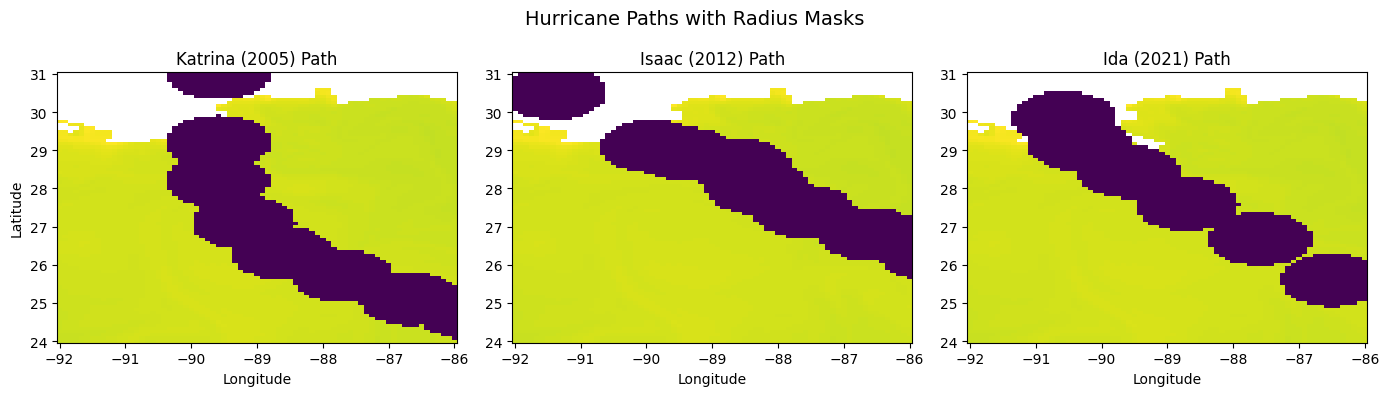

In [268]:
# Create a figure with three subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Hurricane Paths with Radius Masks', fontsize=14)

for i, hurricane in enumerate(hurricane_names):
    latlon_points = get_latlon_within_radius(ds, hurricane_tracks, hurricane, radius_deg=0.7)
    ds_radius = create_radius_mask_ds(ds, latlon_points)
    
    # Plot on the corresponding subplot
    data = ds_radius.isel(time=0)['thetao']
    im = axes[i].pcolormesh(data.longitude, data.latitude, data, shading='auto')
    year = hurricane_tracks[hurricane]['year']
    axes[i].set_title(f'{hurricane.title()} ({year}) Path')
    axes[i].set_xlabel('Longitude')
    if i == 0:  # Only show y-label on leftmost plot
        axes[i].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [317]:
import matplotlib.pyplot as plt
def plot_time_averages(ds, variables, start_date, end_date, hurricane_name):
    """
    Plot time-averaged and zero-mean standardized data for selected variables.

    Parameters:
        ds (xr.Dataset): Input dataset with dimensions ('time', 'points').
        variables (List[str]): List of variable names to include in the plot.
    """
    plt.figure(figsize=(10, 5))

    for var in variables:
        data = ds[var]  # shape (time, points)
        # Compute average over all points at each time step
        avg_time_series = data.mean(dim='points')
        # Standardize to zero mean
        standardized = avg_time_series - avg_time_series.mean()
        # Plot
        plt.plot(ds['time'], standardized, label=var)

    # Add red box for hurricane period
    plt.axvspan(start_date, end_date, color='red', alpha=0.2)

    plt.xlabel('Time')
    plt.ylabel('Standardized daily average')
    plt.title(f'Time-Averaged Standardized Variables during {hurricane_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_time_averages_multiple_hurricanes(hurricane_datasets, variable, hurricane_tracks):
    import matplotlib.dates as mdates
    plt.figure(figsize=(12, 5))

    for hurricane, ds in hurricane_datasets.items():
        data = ds[variable]

        # This handles both (time, points) and (time,)
        if "points" in data.dims:
            avg_time_series = data.mean(dim='points')
        else:
            avg_time_series = data

        standardized = avg_time_series - avg_time_series.mean()

        time = pd.to_datetime(ds['time'].values)
        time_normalized = pd.to_datetime({
            "year": 2000,
            "month": time.month,
            "day": time.day
        })

        line_style = '--' if hurricane == "no_hurricane" else '-'
        line_color = 'gray' if hurricane == "no_hurricane" else None

        plt.plot(time_normalized, standardized, label=hurricane.capitalize(),
                linestyle=line_style, color=line_color)

        # Only highlight real hurricanes
        if hurricane in hurricane_tracks:
            start = pd.to_datetime(hurricane_tracks[hurricane]['start_date'])
            end = pd.to_datetime(hurricane_tracks[hurricane]['end_date'])
            start_norm = pd.Timestamp(year=2000, month=start.month, day=start.day)
            end_norm = pd.Timestamp(year=2000, month=end.month, day=end.day)
            plt.axvspan(start_norm, end_norm, color='red', alpha=0.1)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_xlim(pd.Timestamp('2000-08-15'), pd.Timestamp('2000-09-15'))

    plt.xlabel('Date (MM-DD)')
    plt.ylabel(variable)
    plt.title(f'Time-Averaged Standardized {variable.upper()} (Aug-Oct)')
    plt.legend(title="Hurricane")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    import os
    os.makedirs('images/time_average', exist_ok=True)
    
    # Save plot for each hurricane
    for hurricane in hurricane_datasets.keys():
        if hurricane != "no_hurricane":
            filename = f'images/time_average/{hurricane}_{variable}.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()




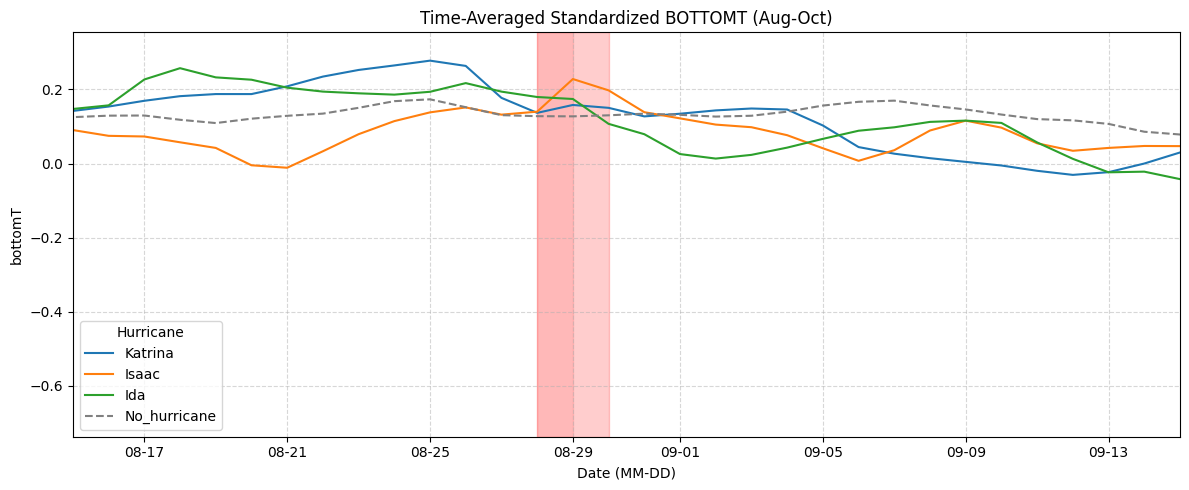

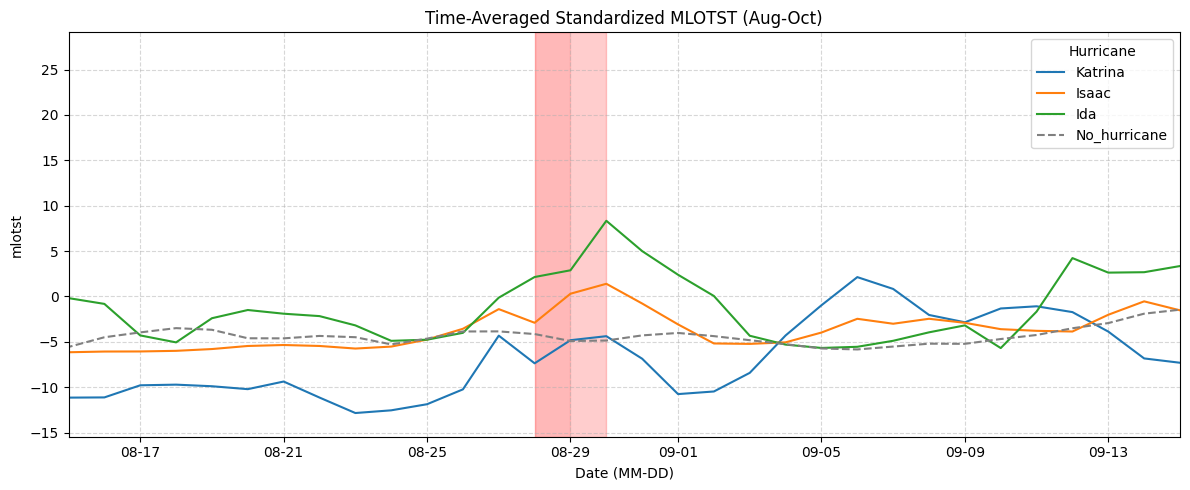

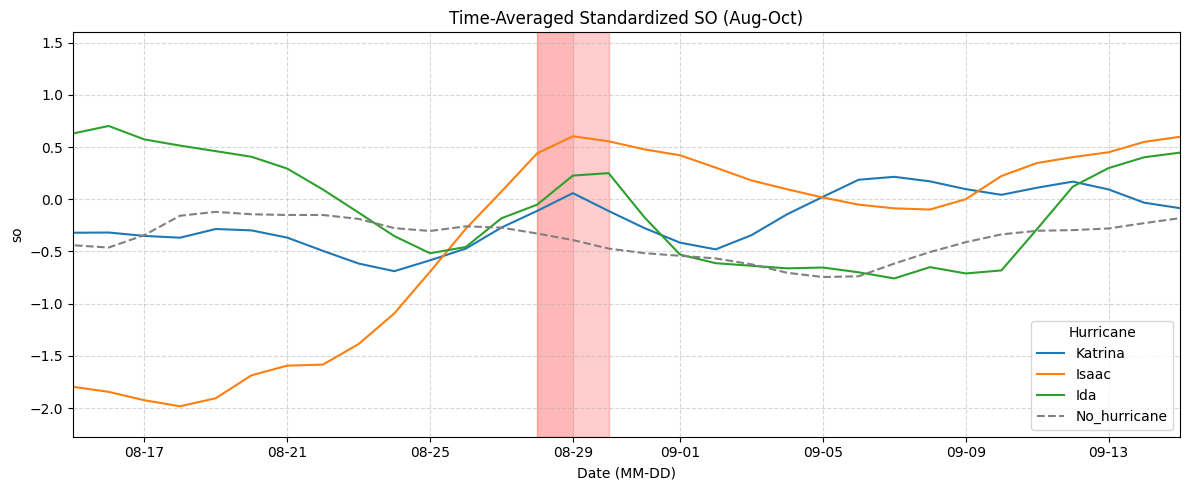

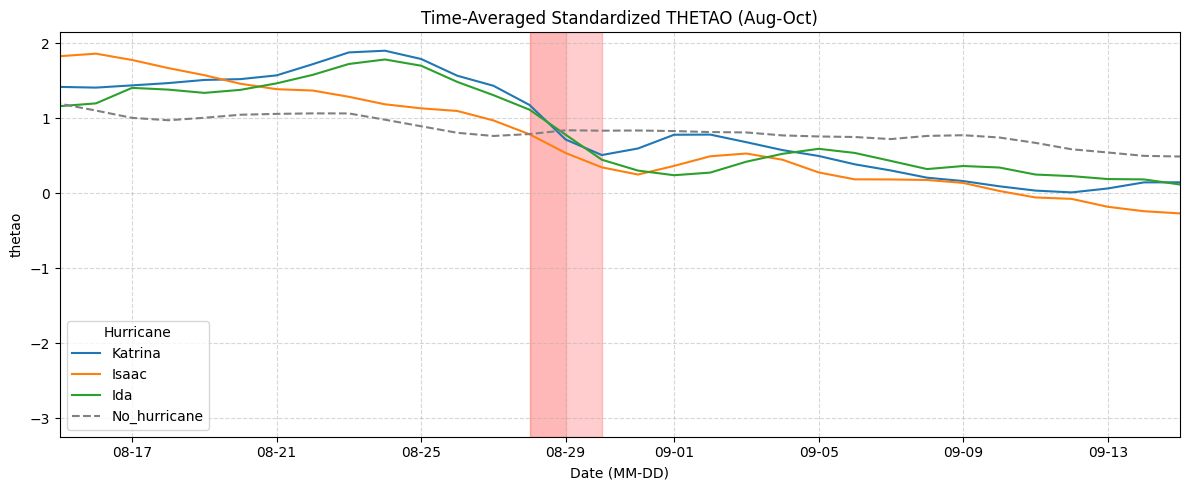

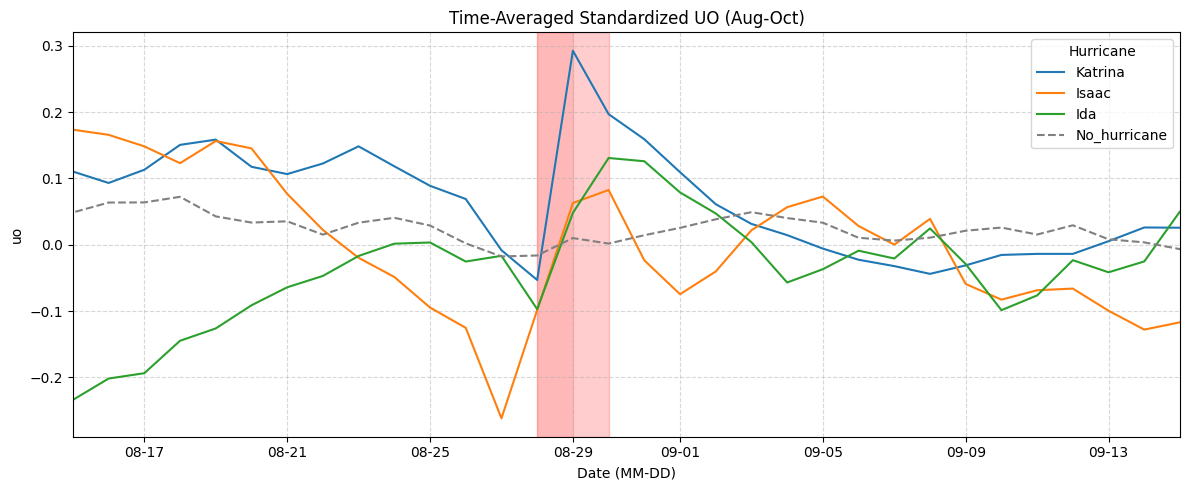

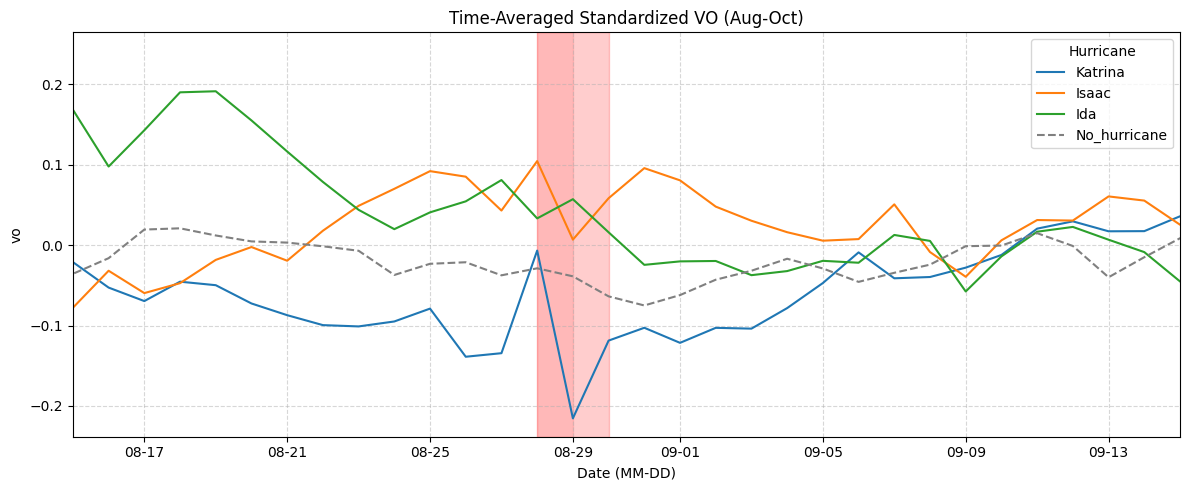

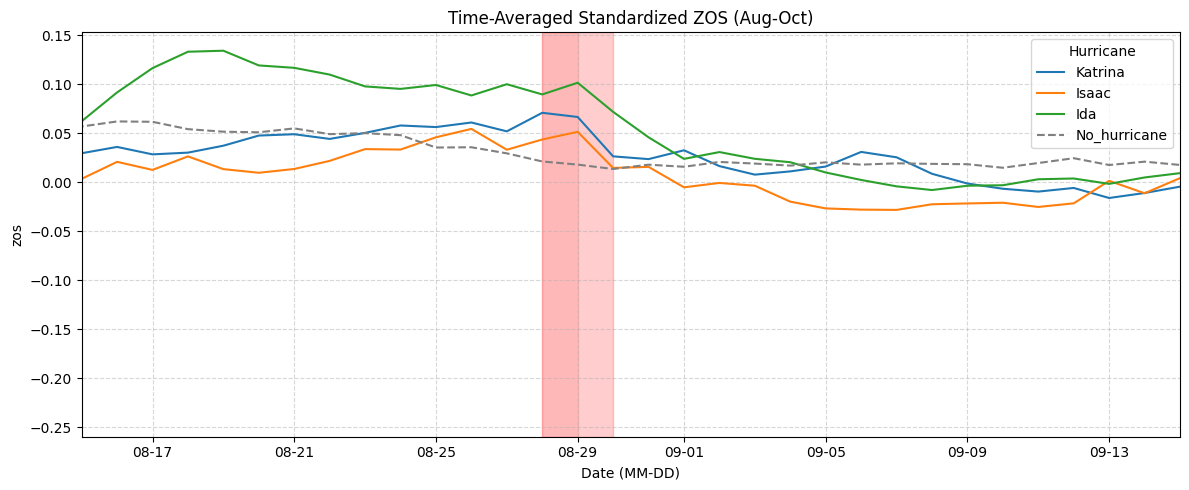

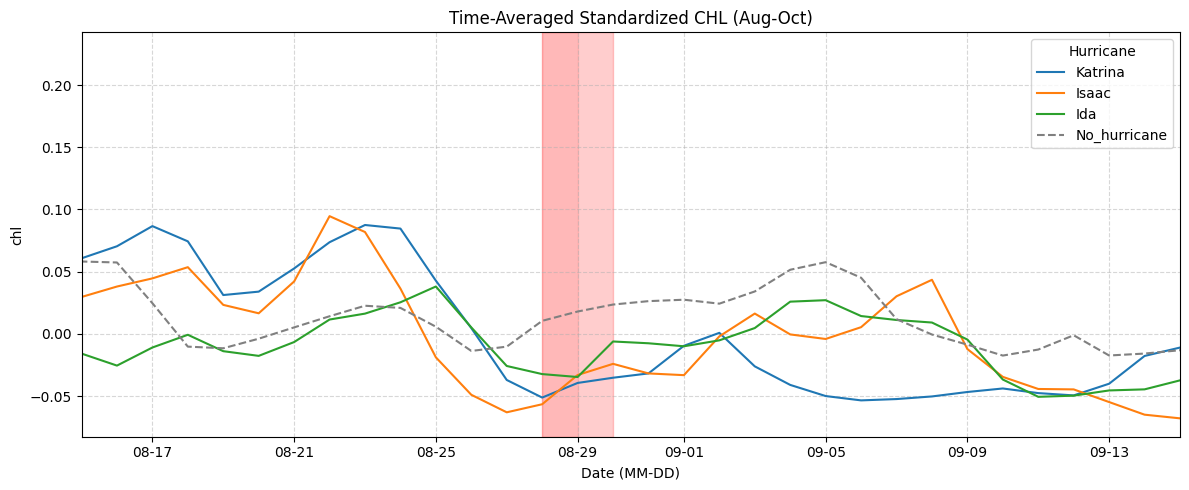

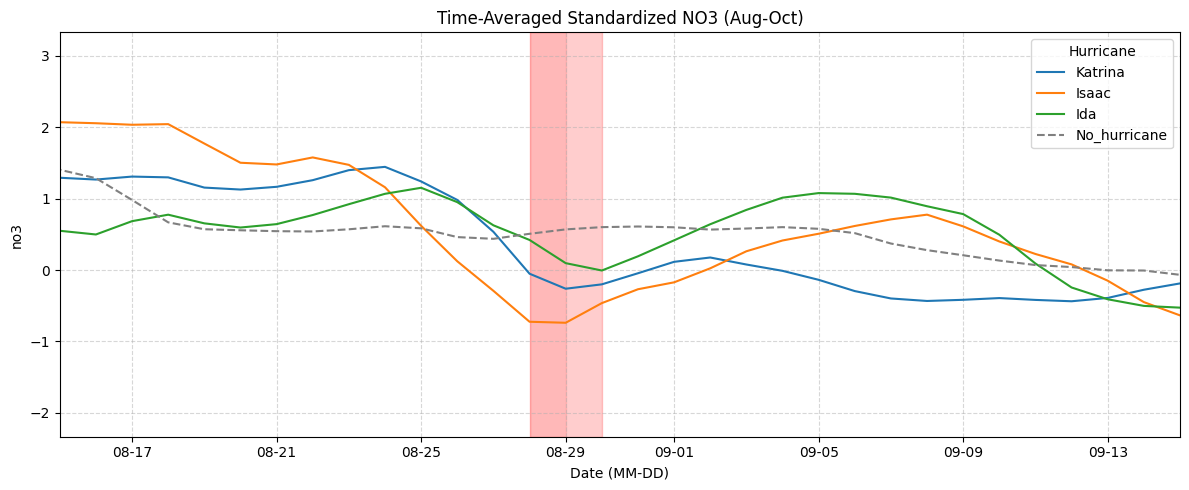

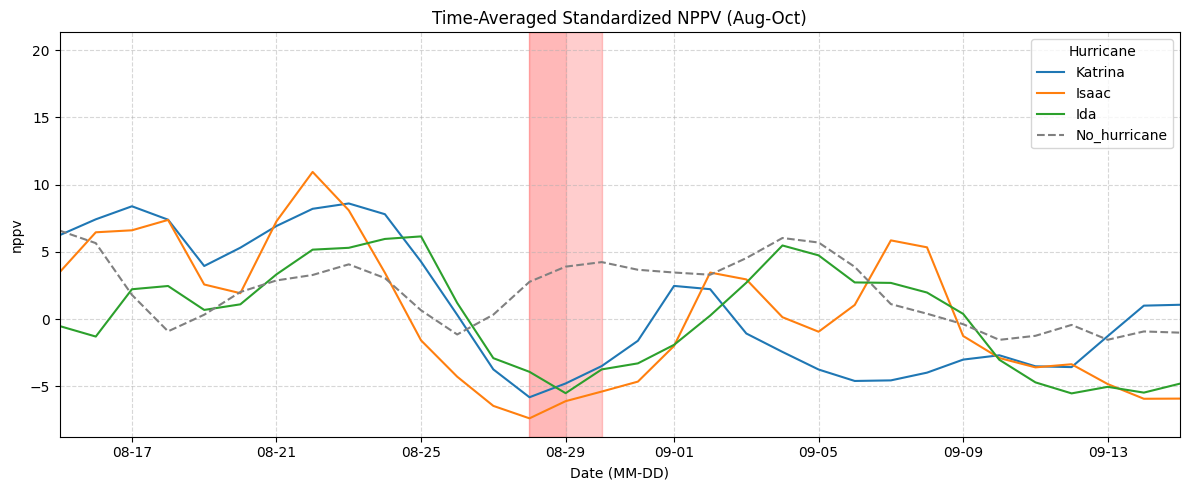

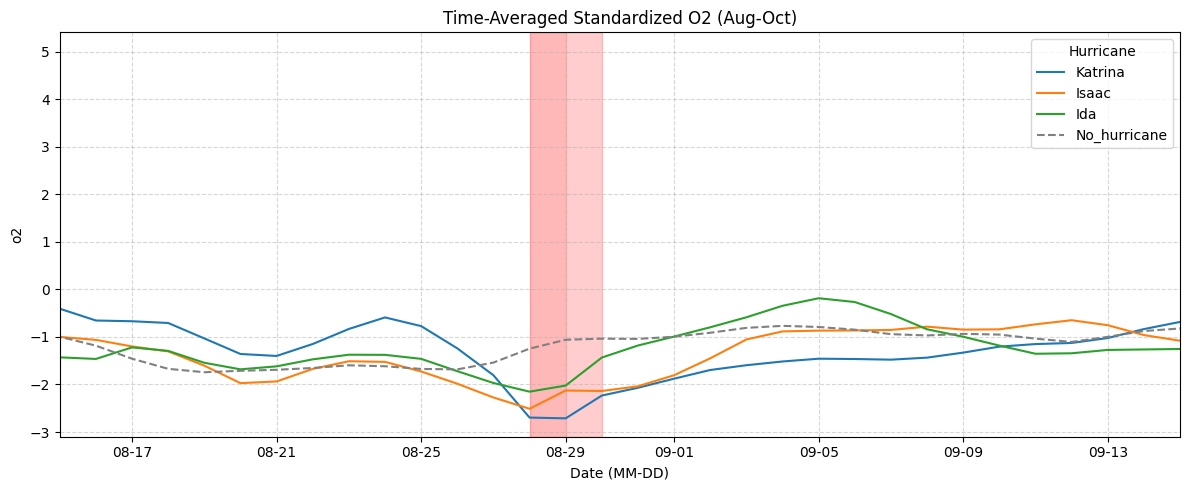

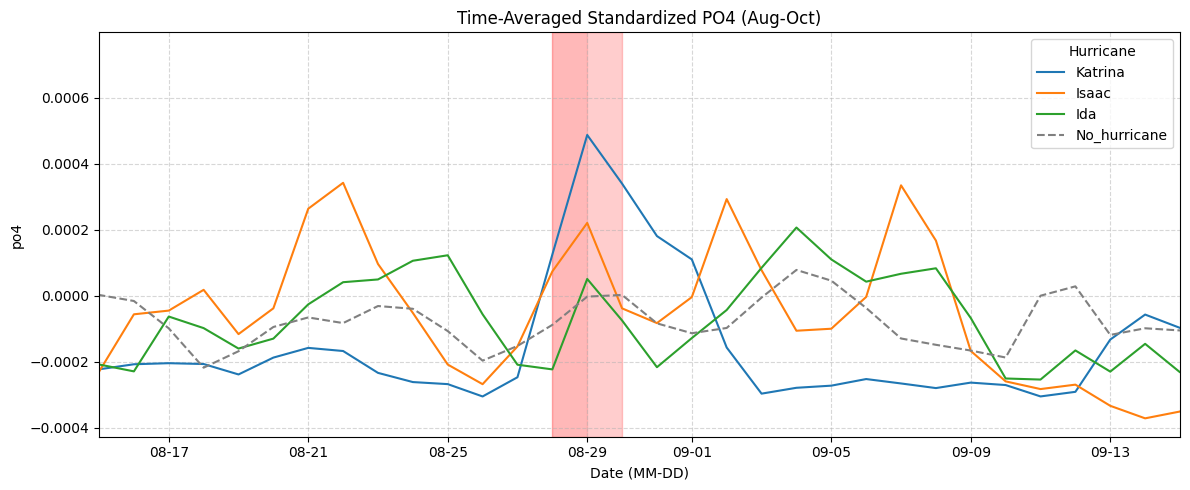

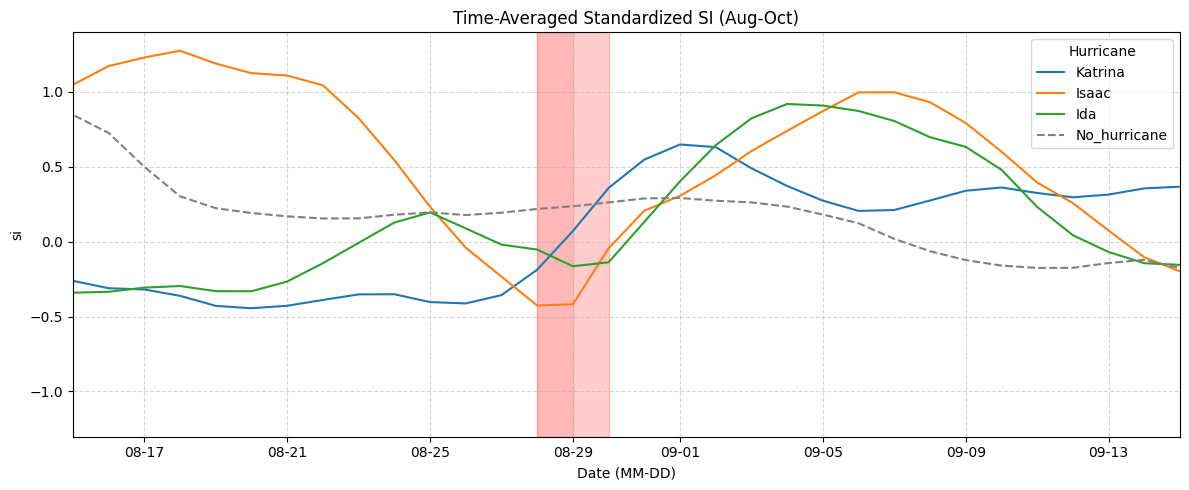

In [318]:
from collections import defaultdict

hurricane_datasets = {}
no_hurricane_daily_averages = defaultdict(list)  # var -> list of DataFrames

for hurricane in hurricane_names:
    # 1. Get lat/lon for this hurricane path
    latlon_points = get_latlon_within_radius(ds, hurricane_tracks, hurricane, radius_deg=0.6)

    # 2. Extract hurricane data for that year
    ds_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=int(hurricane_tracks[hurricane]['year']))
    hurricane_datasets[hurricane] = ds_hurricane

    # 3. Extract no-hurricane years over the same latlon path
    ds_no_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=no_hurricane_years)

    # 4. Align all no-hurricane data to month-day and compute average per day
    for var in ds_no_hurricane.data_vars:
        df = ds_no_hurricane[var].to_dataframe().reset_index()
        df["date"] = pd.to_datetime(df["time"])
        df["synthetic_date"] = pd.to_datetime({
            "year": 2000,
            "month": df["date"].dt.month,
            "day": df["date"].dt.day
        })
        grouped = df.groupby("synthetic_date")[var].mean().reset_index()
        grouped.set_index("synthetic_date", inplace=True)
        no_hurricane_daily_averages[var].append(grouped)

# 5. After loop: average across the 3 no-hurricane tracks
no_hurricane_combined = {}

for var, df_list in no_hurricane_daily_averages.items():
    df_concat = pd.concat(df_list, axis=1)
    df_mean = df_concat.mean(axis=1)
    no_hurricane_combined[var] = df_mean

# 6. Convert to xarray Dataset
df_combined = pd.DataFrame(no_hurricane_combined)
df_combined.index.name = "time"
ds_no_hurricane_final = xr.Dataset.from_dataframe(df_combined)

# 7. Add to datasets
hurricane_datasets["no_hurricane"] = ds_no_hurricane_final

for var in ds.data_vars:
    if var not in ['siconc','sithick','vsi','usi']:
        plot_time_averages_multiple_hurricanes(
            hurricane_datasets,
            variable=var,
            hurricane_tracks=hurricane_tracks
        )


In [319]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import os

def plot_hurricane_vs_nohurricane(ds_hurricane, ds_no_hurricane, var_name, hurricane_meta, hurricane_name):
    """
    Plots weekly average, max, and min values of `var_name` from August 1 to October 31
    comparing a hurricane year vs. average of multiple no-hurricane years.
    Highlights the week(s) during which the hurricane occurred.

    Parameters:
        ds_hurricane (xr.Dataset): Dataset for the hurricane year.
        ds_no_hurricane (xr.Dataset): Dataset for non-hurricane years.
        var_name (str): Name of the data variable to analyze.
        hurricane_meta (dict): Dict with 'year', 'start_date', 'end_date' of the hurricane.
        hurricane_name (str): Name of the hurricane (e.g., 'katrina').
    """
    def preprocess(ds):
        df = ds[var_name].to_dataframe().reset_index()
        df["date"] = pd.to_datetime(df["time"])
        df["week"] = df["date"].dt.isocalendar().week
        df["month"] = df["date"].dt.month
        return df[(df["month"] >= 8) & (df["month"] <= 10)]

    df_h = preprocess(ds_hurricane)
    df_nh = preprocess(ds_no_hurricane)

    stats_h = df_h.groupby("week")[var_name].agg(["mean", "min", "max"])
    stats_nh = df_nh.groupby("week")[var_name].agg(["mean", "min", "max"])

    weeks = sorted(set(stats_h.index) | set(stats_nh.index))
    stats_h = stats_h.reindex(weeks)
    stats_nh = stats_nh.reindex(weeks)

    x = np.arange(len(weeks))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 6))

    # Bar plots
    ax.bar(x - width/2, stats_h["mean"], width, label=f"{hurricane_name.capitalize()} Avg", alpha=0.7, color="tab:red")
    ax.errorbar(x - width/2, stats_h["mean"], 
                yerr=[stats_h["mean"] - stats_h["min"], stats_h["max"] - stats_h["mean"]],
                fmt='none', ecolor='tab:red', capsize=5)

    ax.bar(x + width/2, stats_nh["mean"], width, label="No-Hurricane Avg", alpha=0.7, color="tab:blue")
    ax.errorbar(x + width/2, stats_nh["mean"], 
                yerr=[stats_nh["mean"] - stats_nh["min"], stats_nh["max"] - stats_nh["mean"]],
                fmt='none', ecolor='tab:blue', capsize=5)

    # Y-axis limits
    all_mins = np.minimum(stats_h["min"].min(), stats_nh["min"].min())
    all_maxs = np.maximum(stats_h["max"].max(), stats_nh["max"].max())
    y_margin = (all_maxs - all_mins) * 0.05
    ax.set_ylim(all_mins - y_margin, all_maxs + y_margin)

    # Highlight hurricane week(s)
    start_date = pd.to_datetime(hurricane_meta["start_date"])
    end_date = pd.to_datetime(hurricane_meta["end_date"])
    hurricane_weeks = pd.date_range(start_date, end_date).isocalendar().week.unique()

    for week in hurricane_weeks:
        if week in weeks:
            idx = weeks.index(week)
            ax.axvspan(idx - 0.5, idx + 0.5, color="gray", alpha=0.3, label=f"{hurricane_name.capitalize()} Week")

    # Avoid duplicate legend entry
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    ax.set_xlabel("ISO Week Number (Aug - Oct)")
    ax.set_ylabel(var_name)
    ax.set_title(f"Weekly Stats of '{var_name}' - {hurricane_name.capitalize()} vs. No-Hurricane")
    ax.set_xticks(x)
    ax.set_xticklabels(weeks)
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    os.makedirs("images/weekly_average", exist_ok=True)
    
    # Save figure
    filename = f"images/weekly_average/{hurricane_name}_{var_name}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


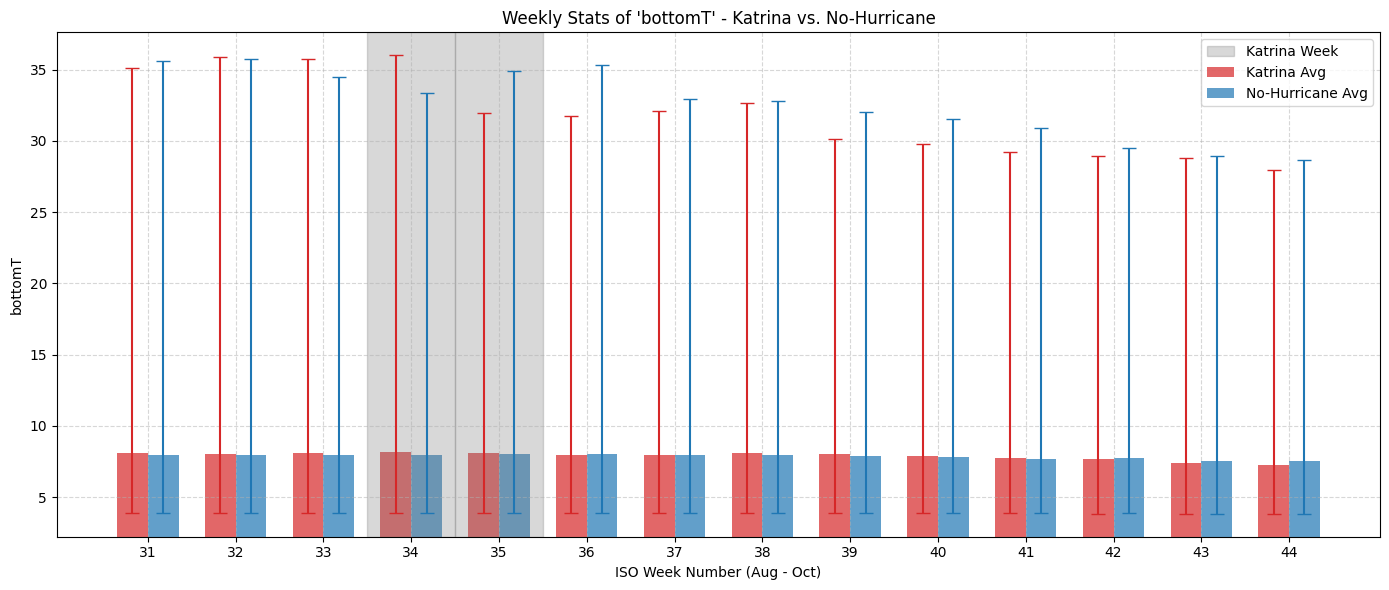

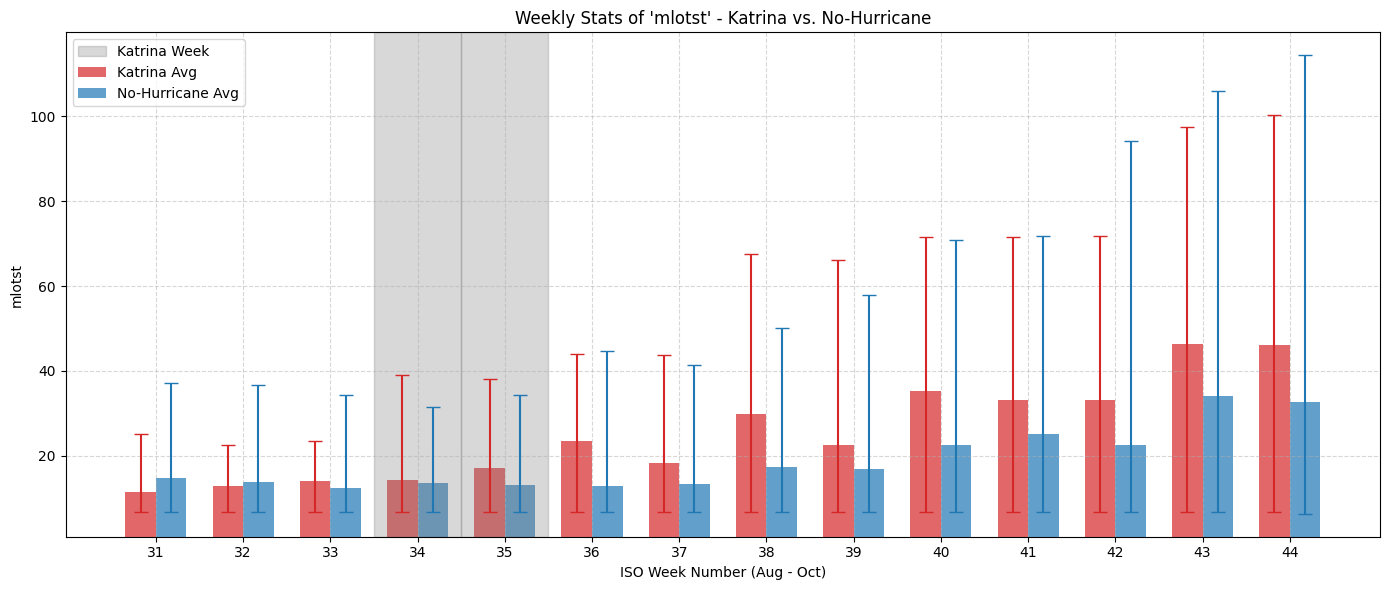

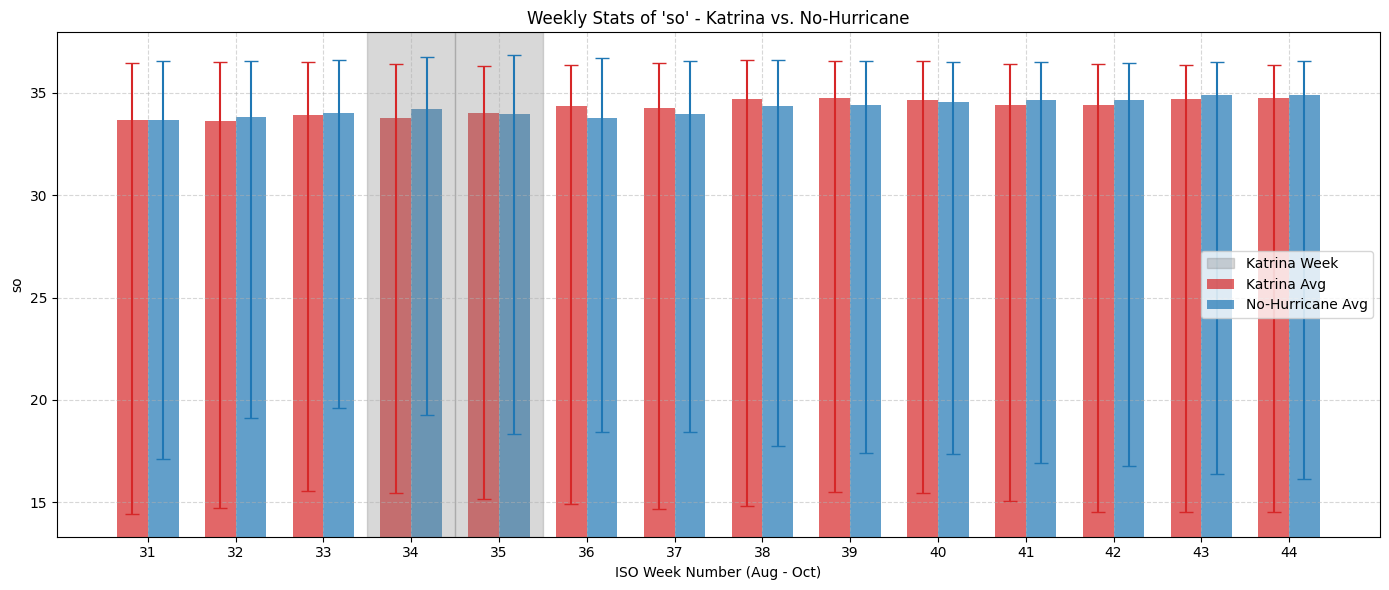

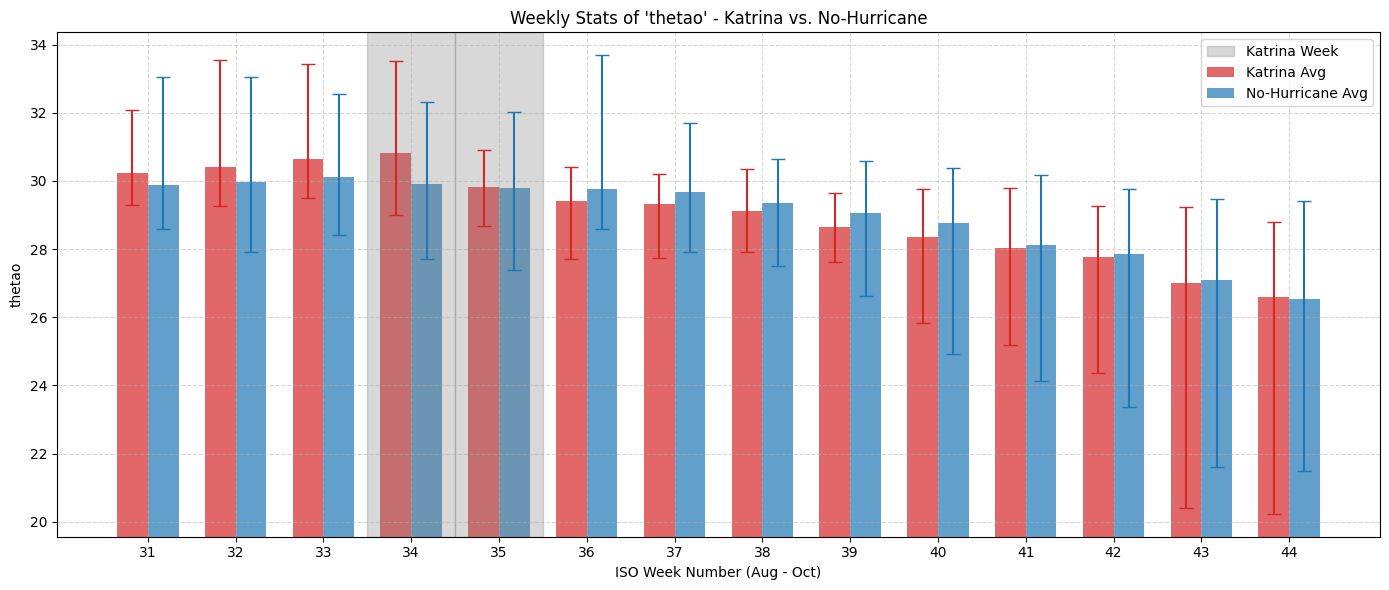

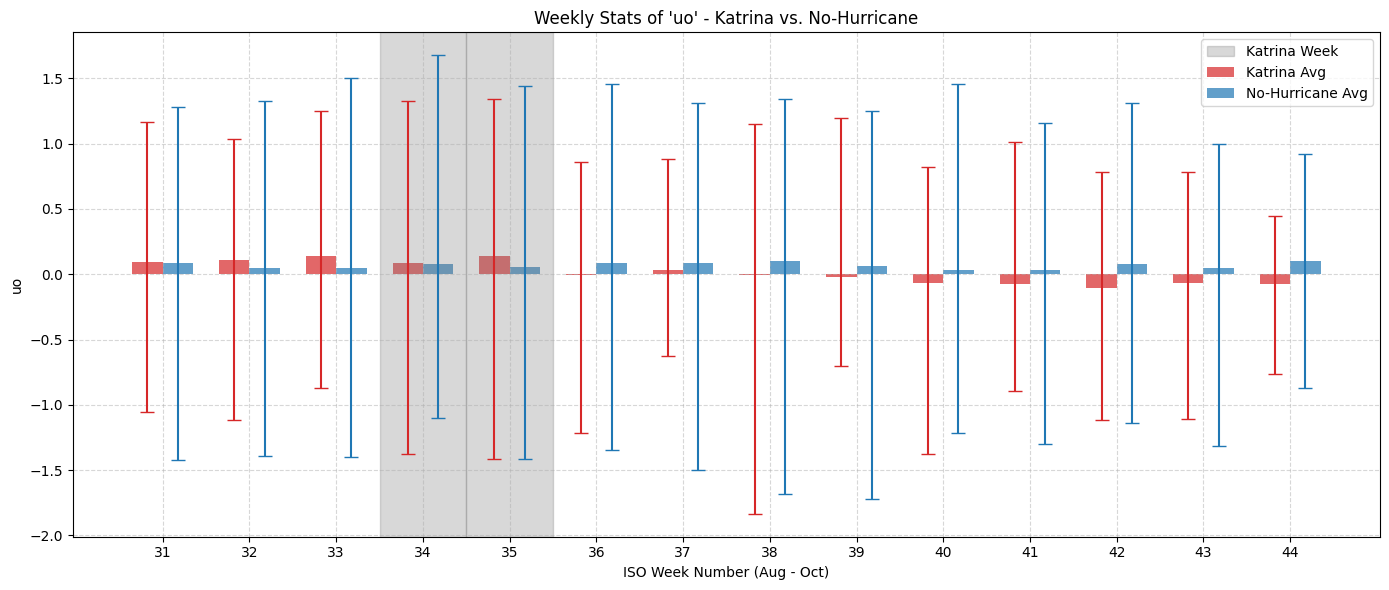

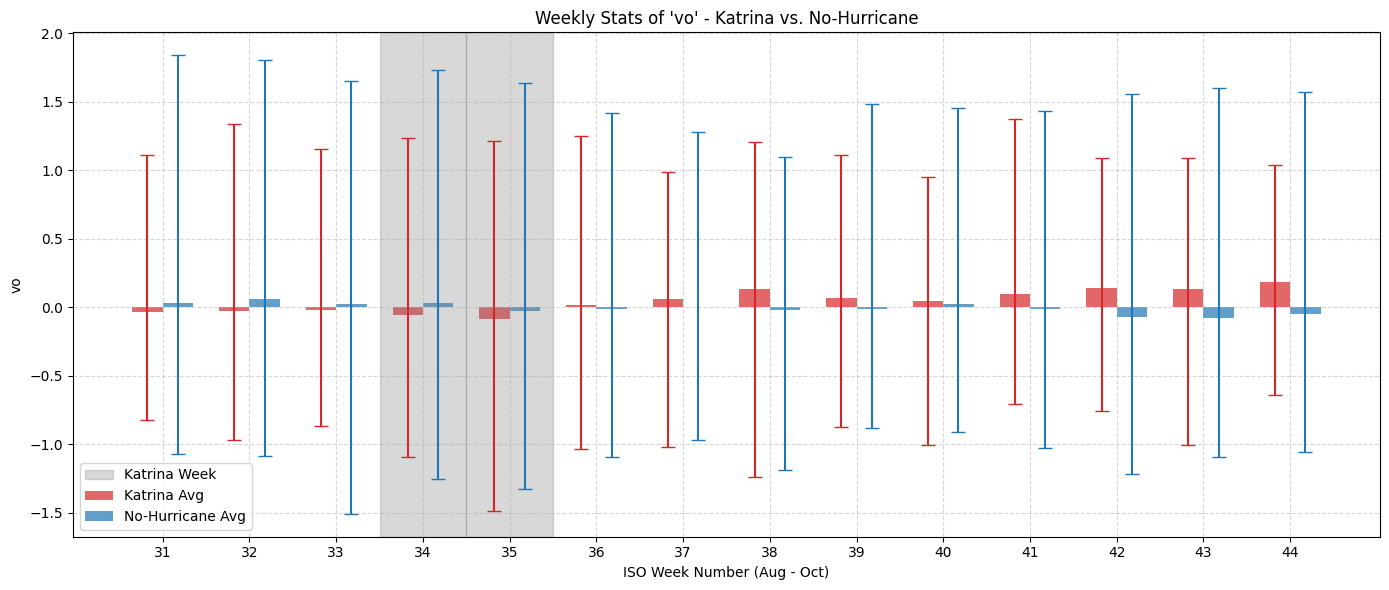

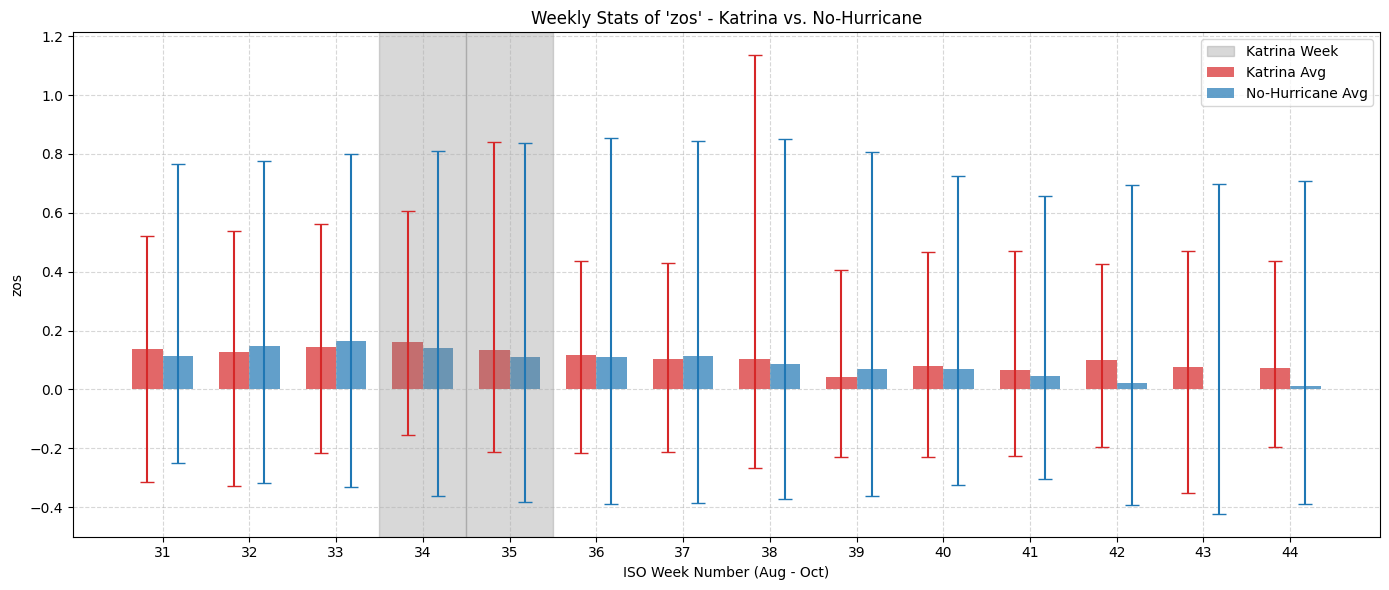

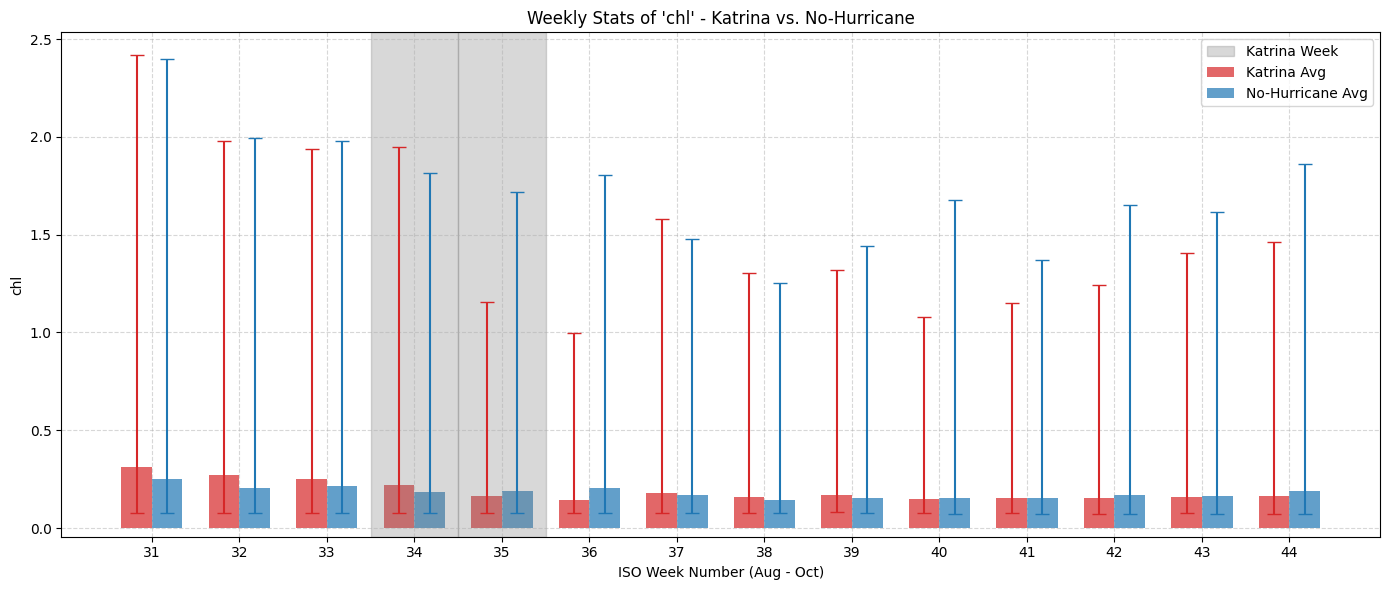

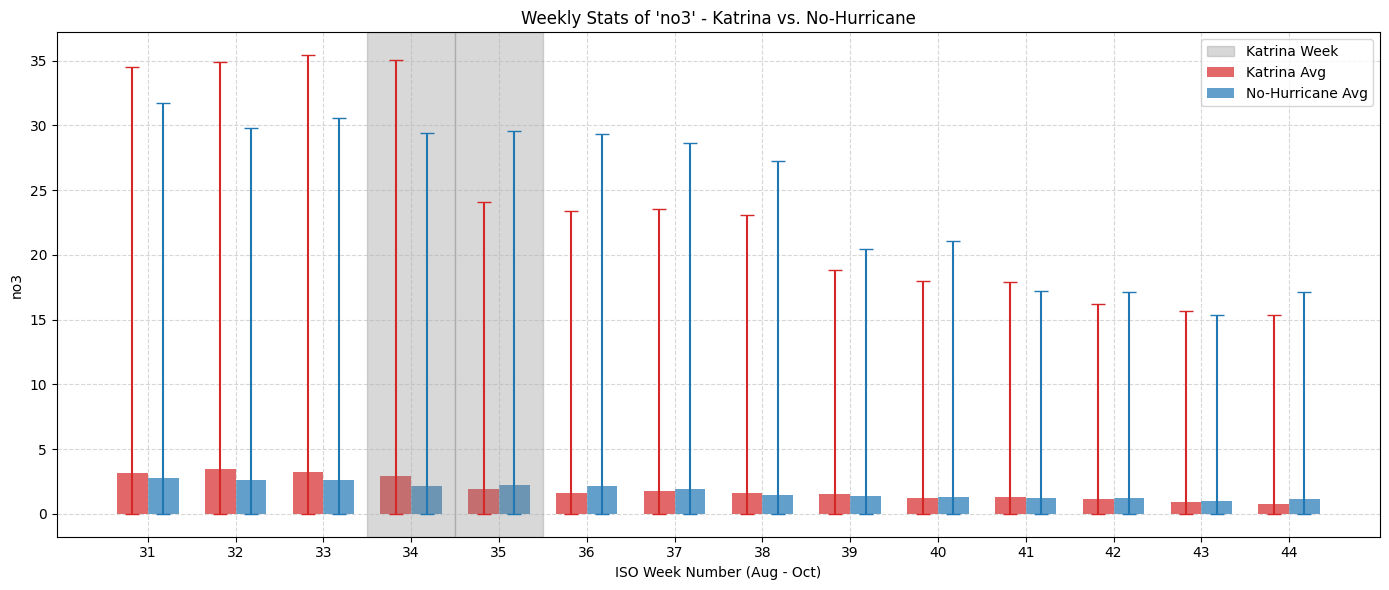

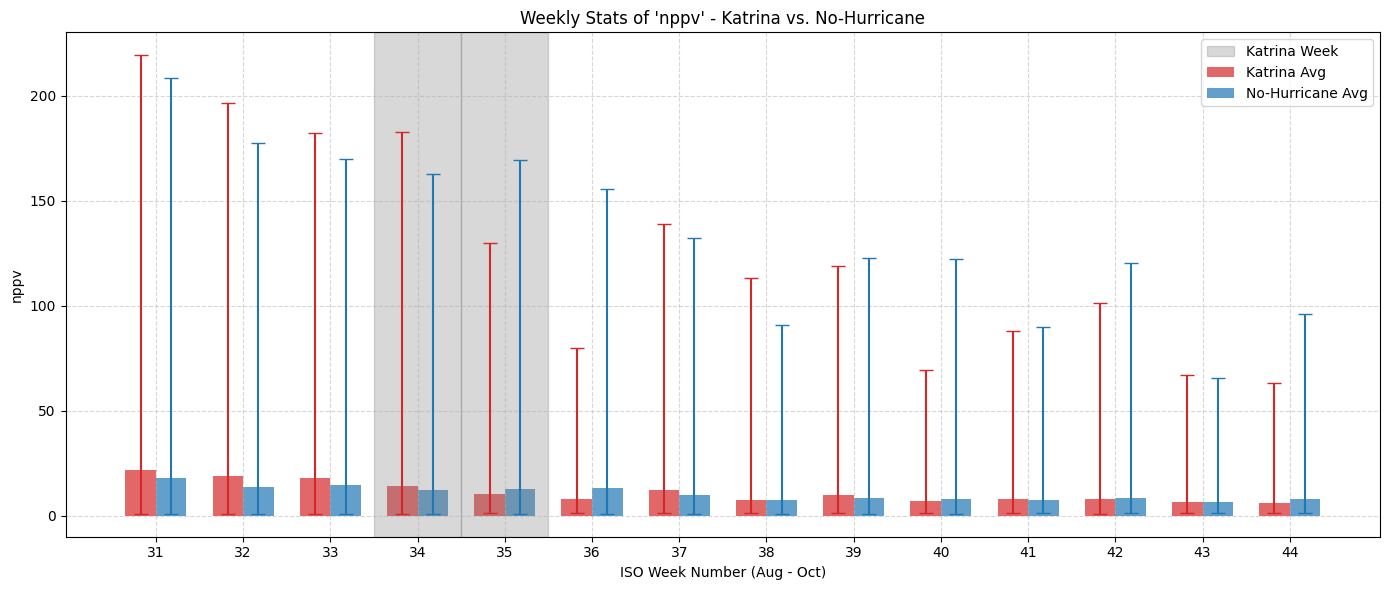

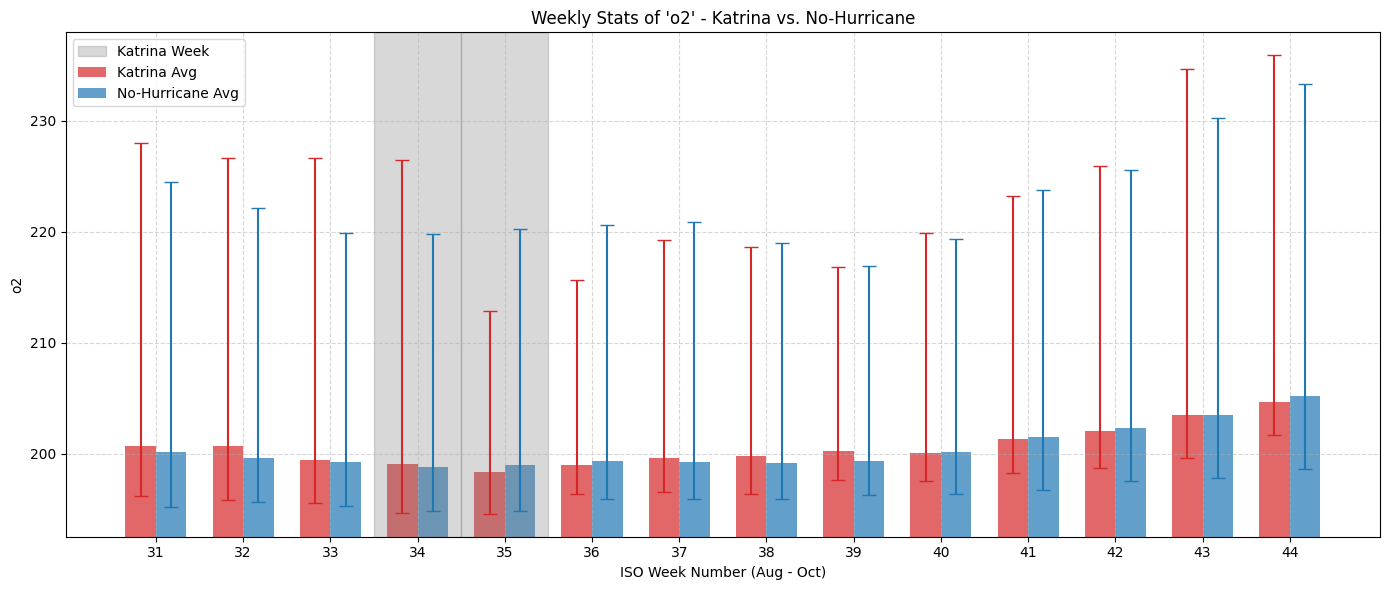

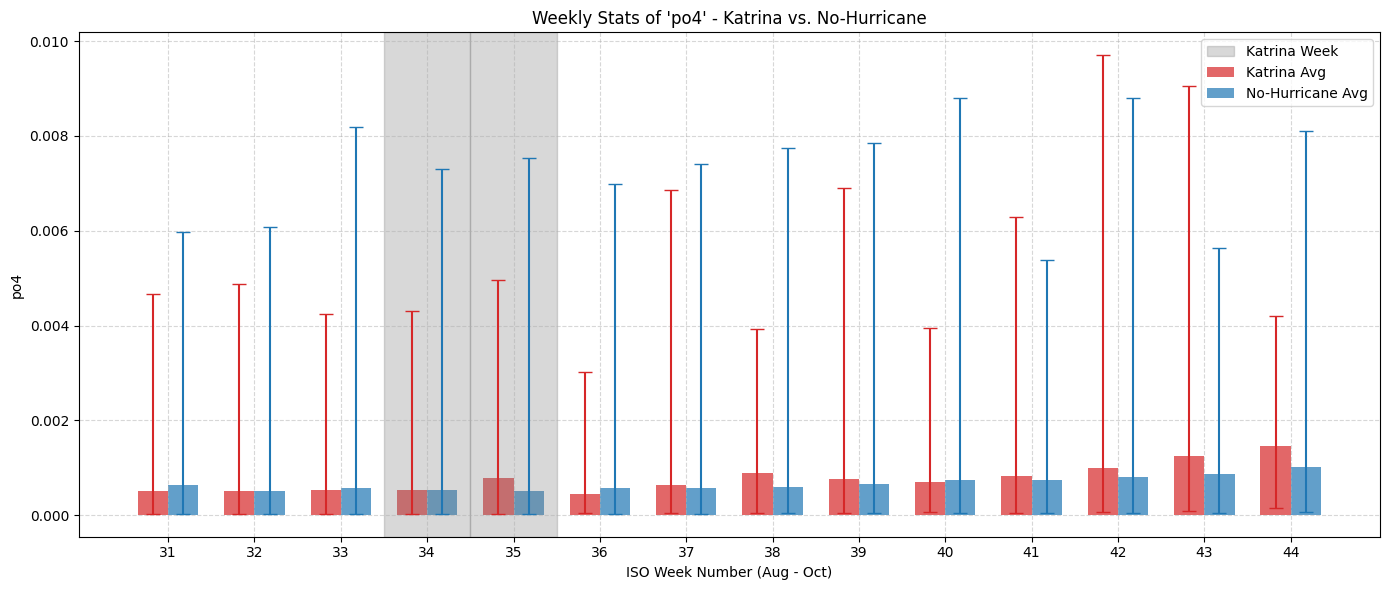

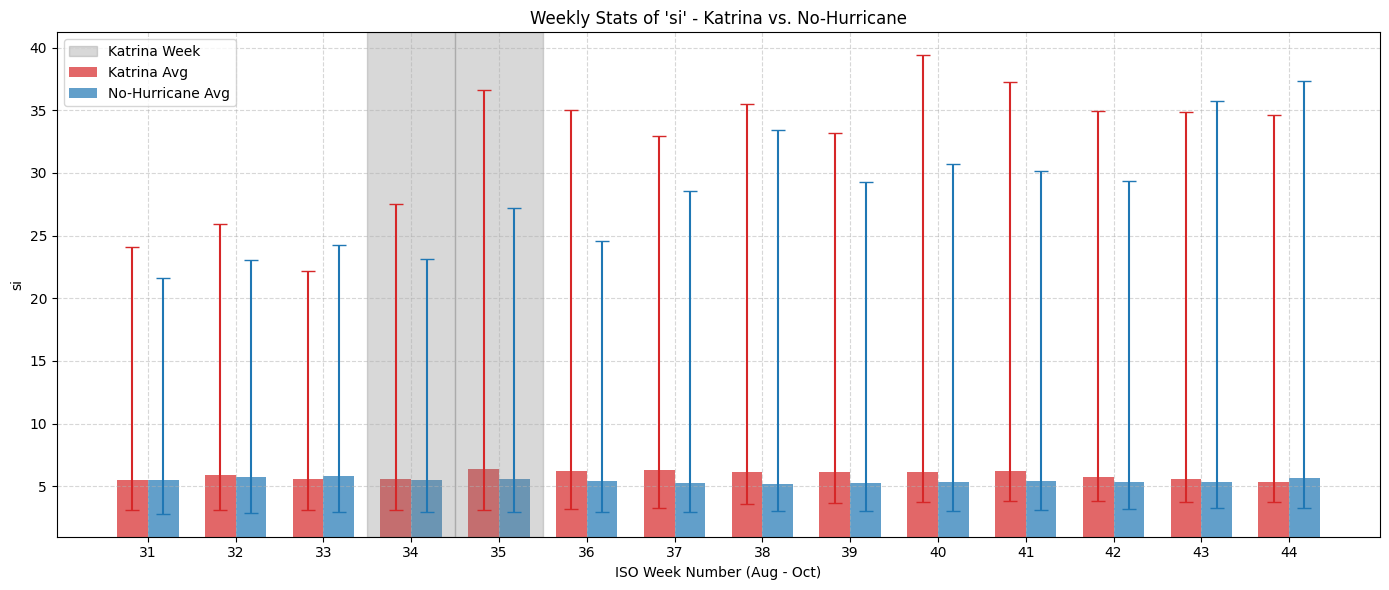

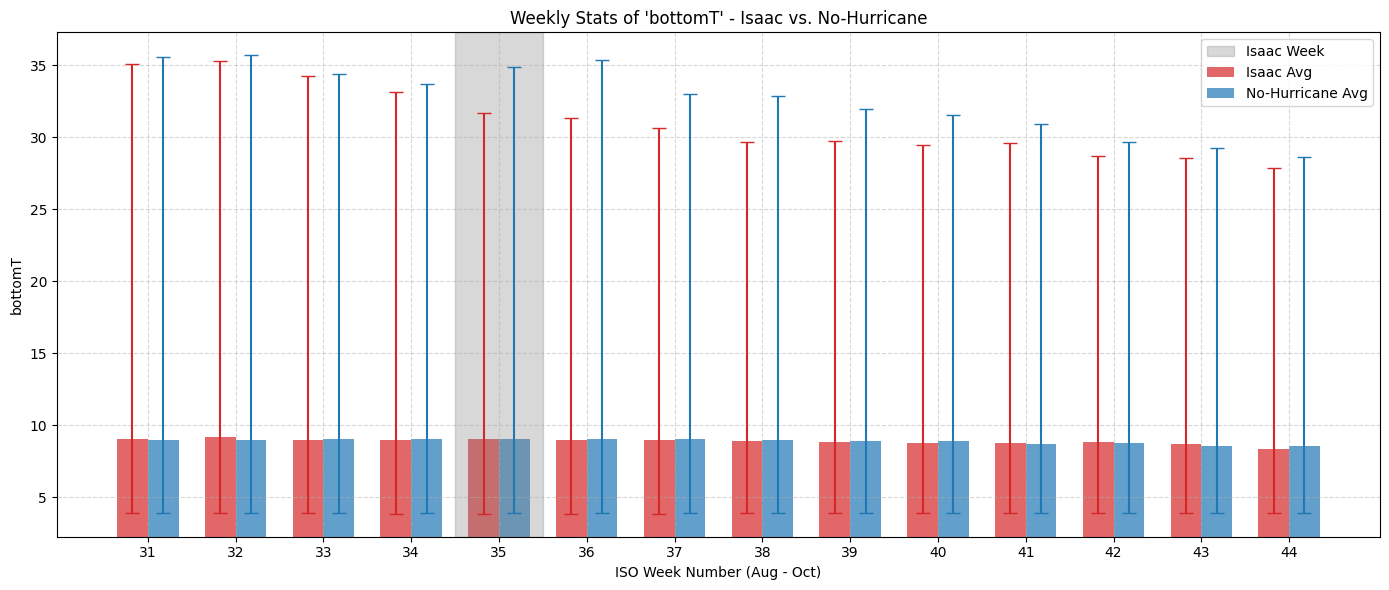

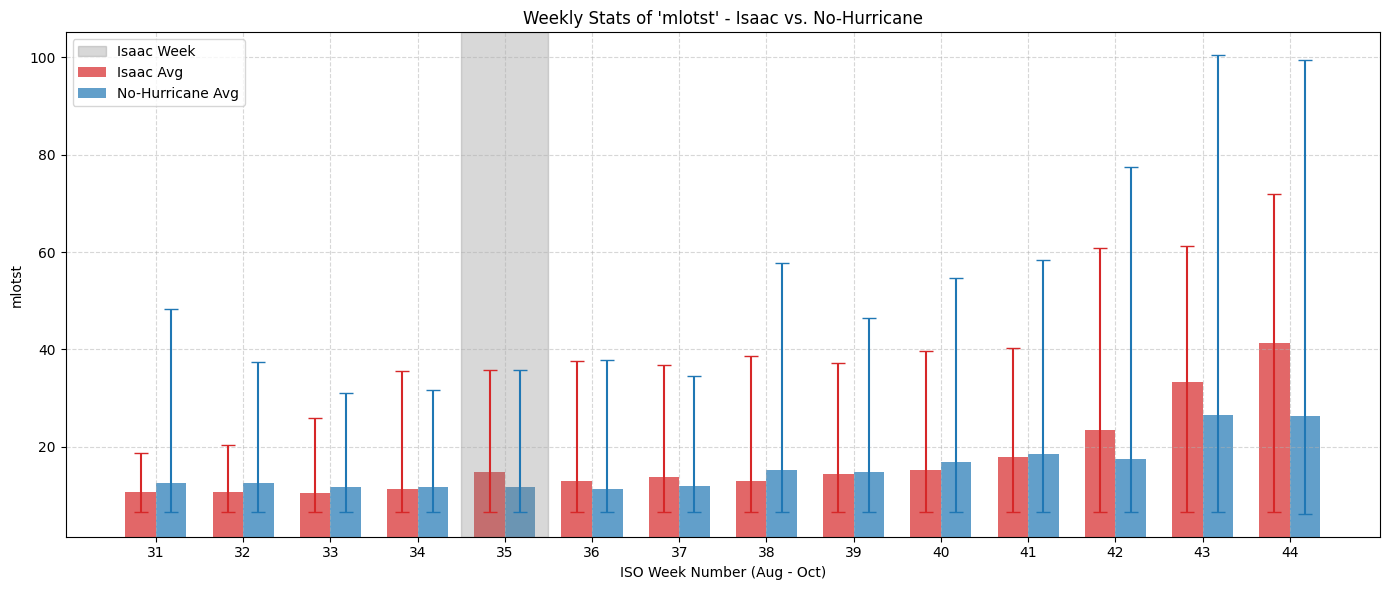

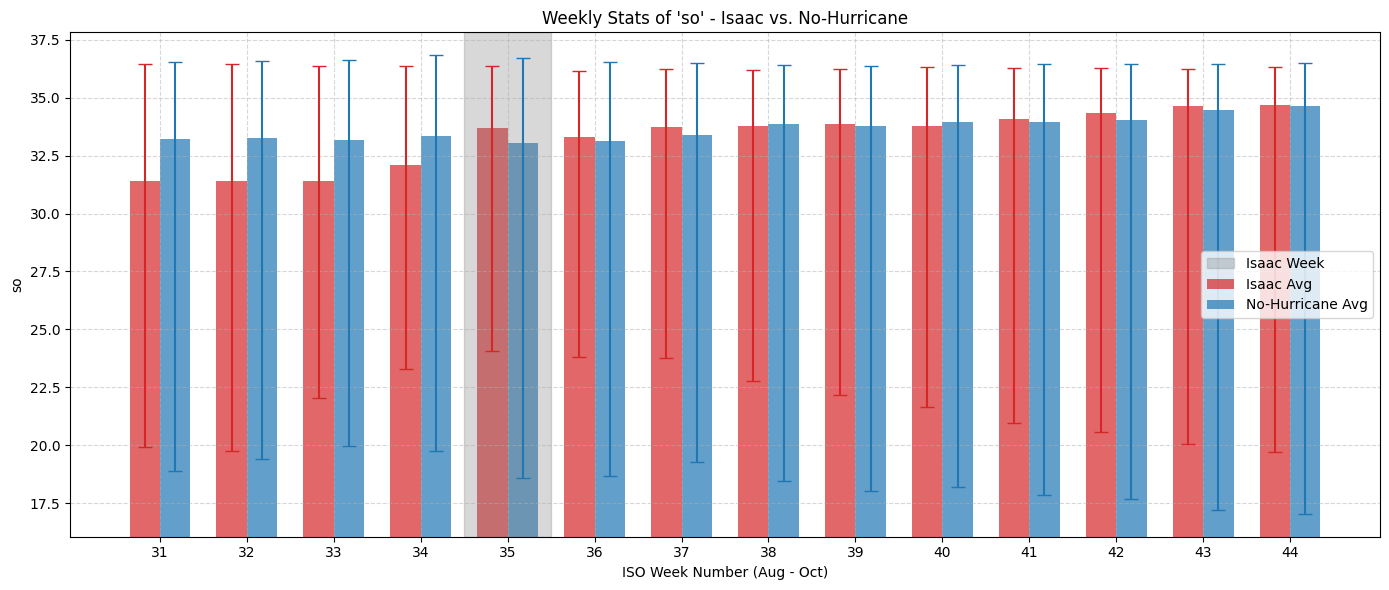

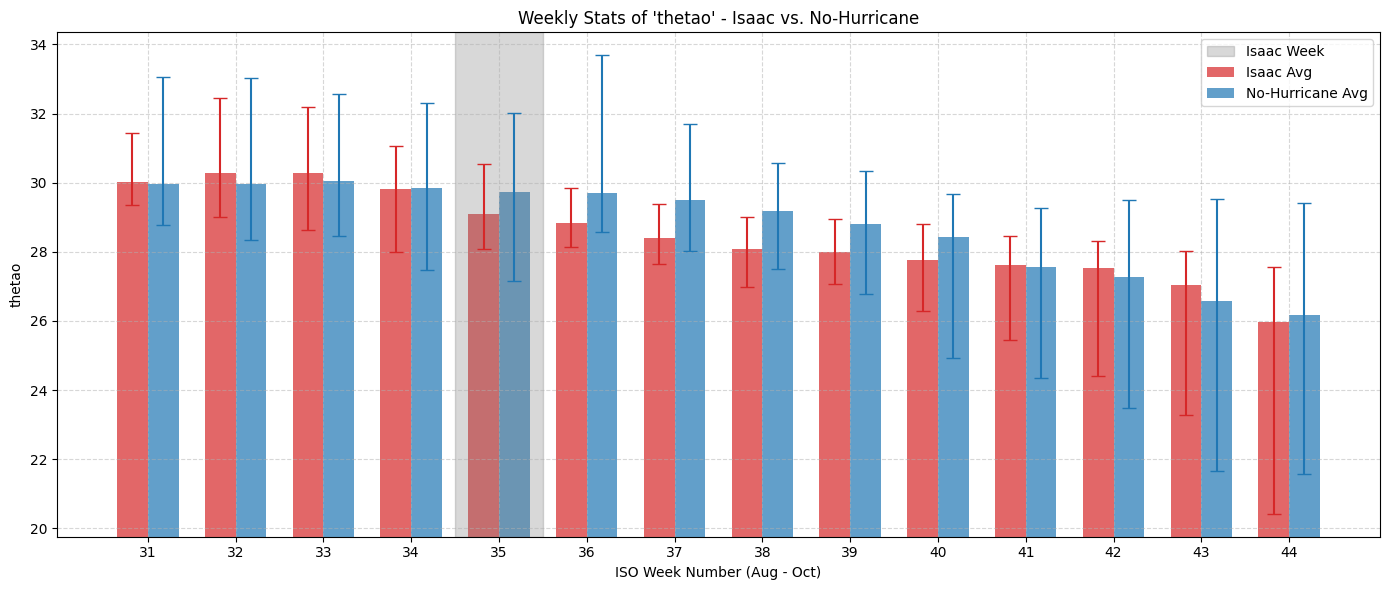

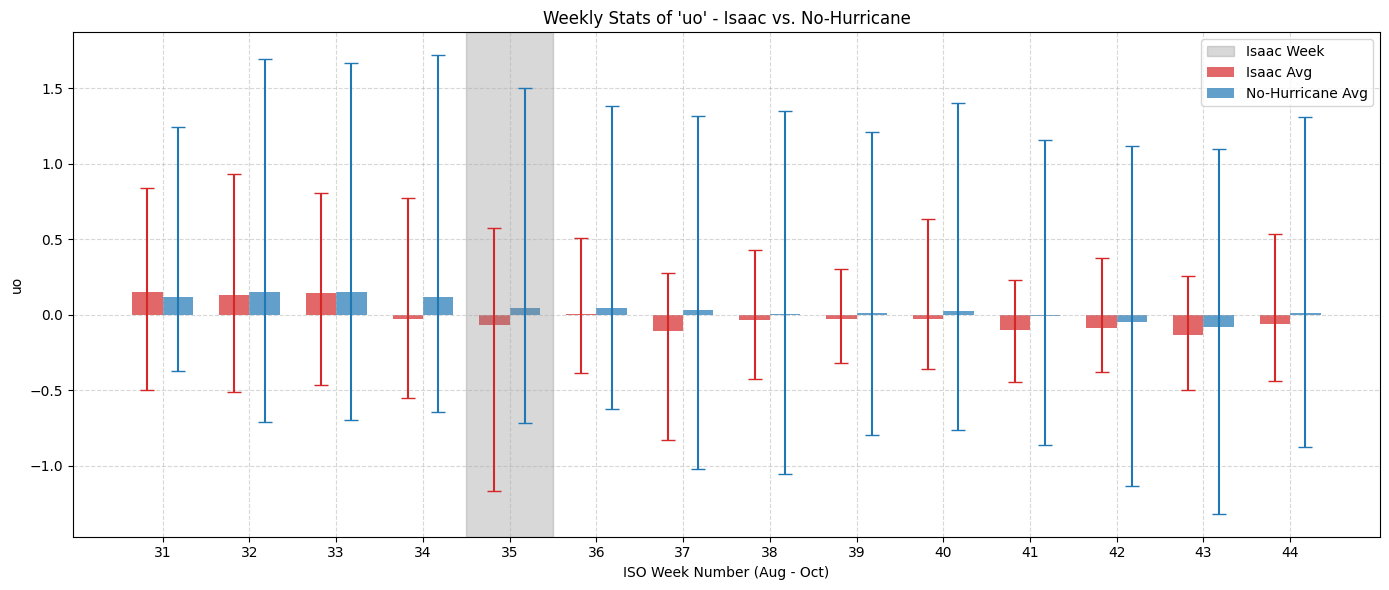

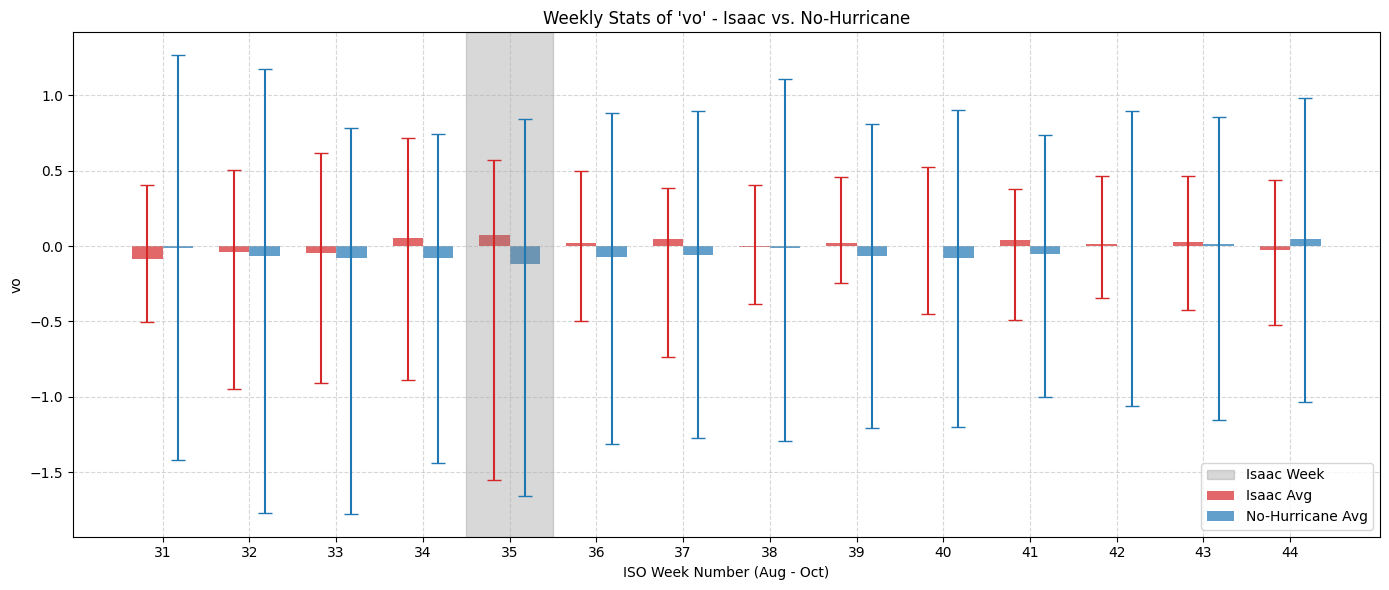

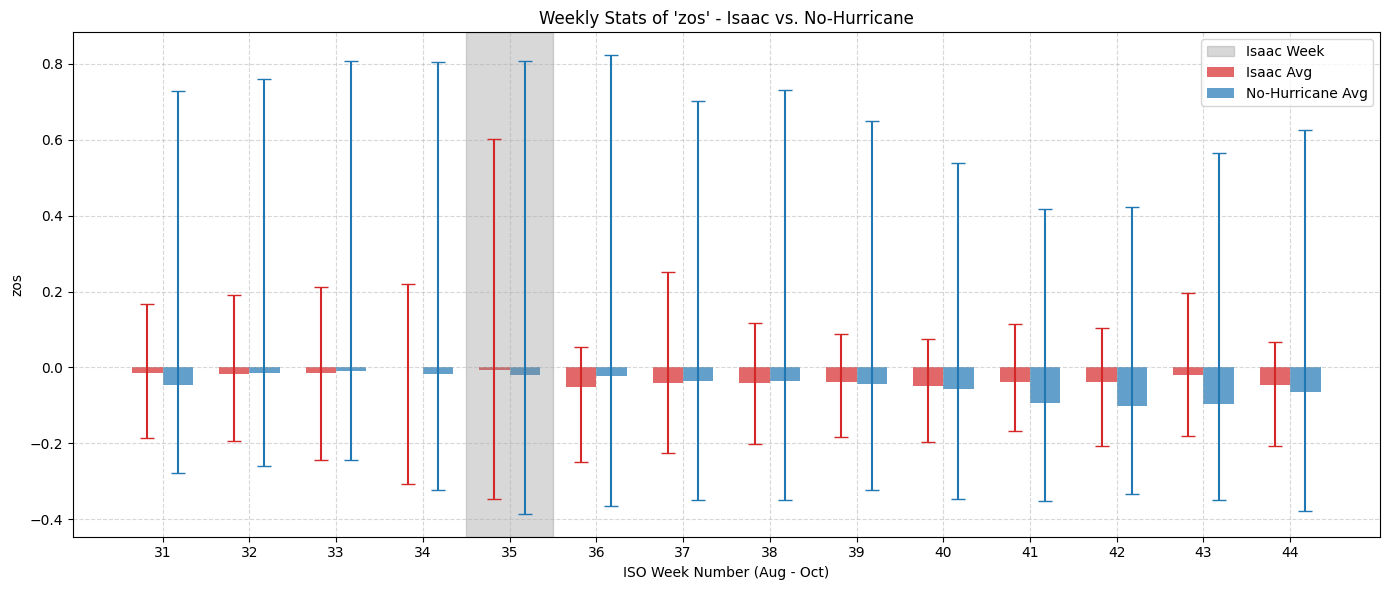

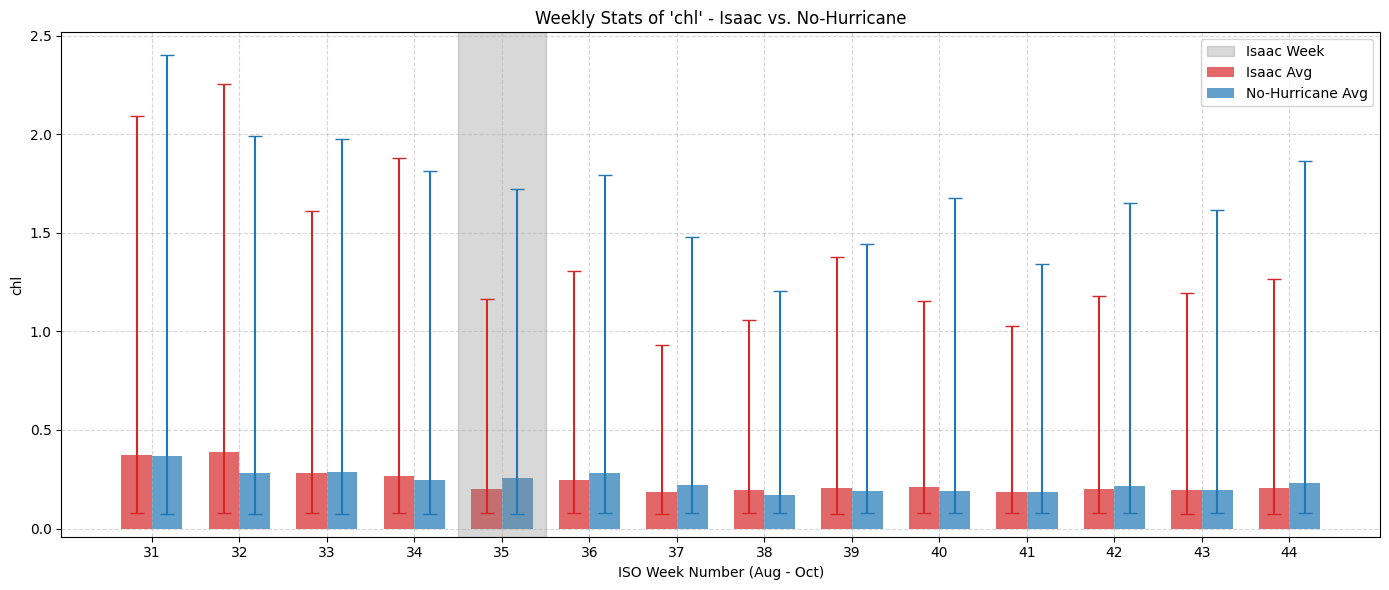

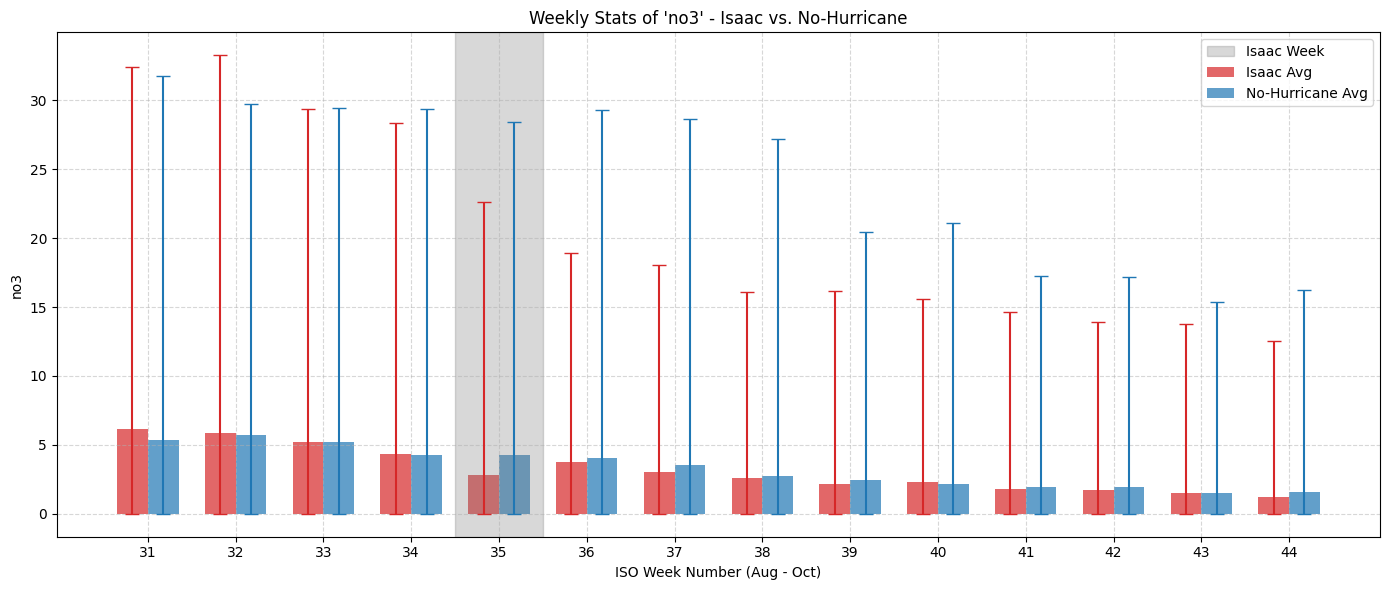

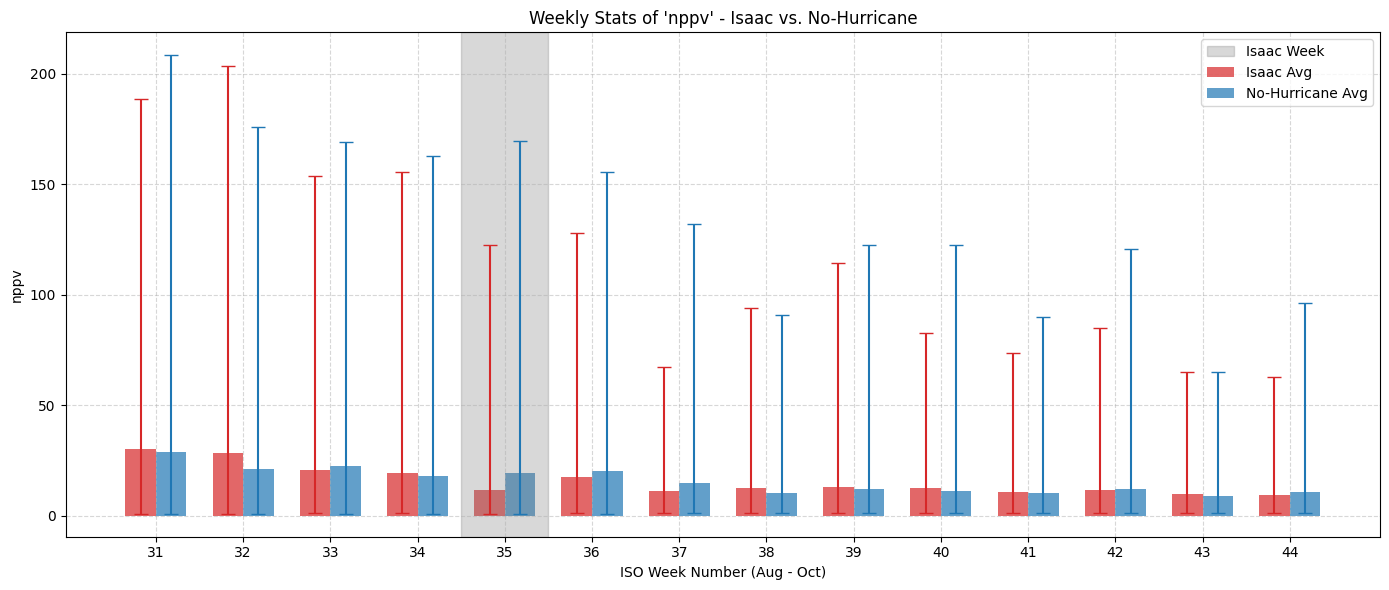

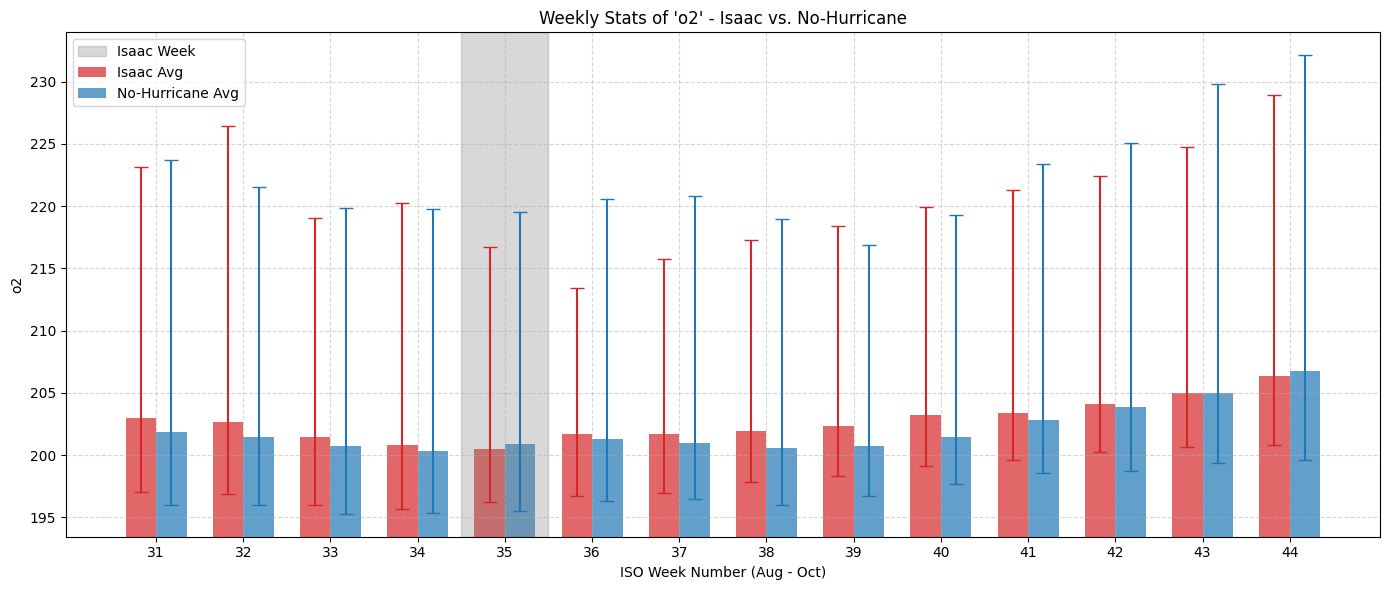

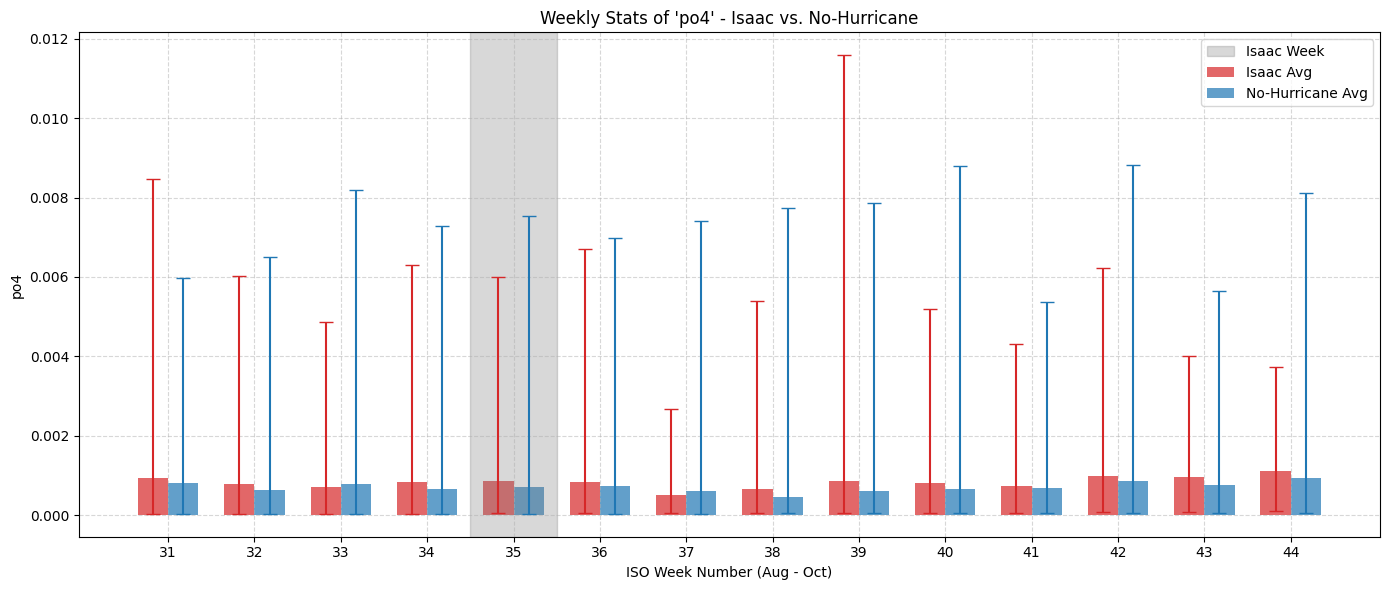

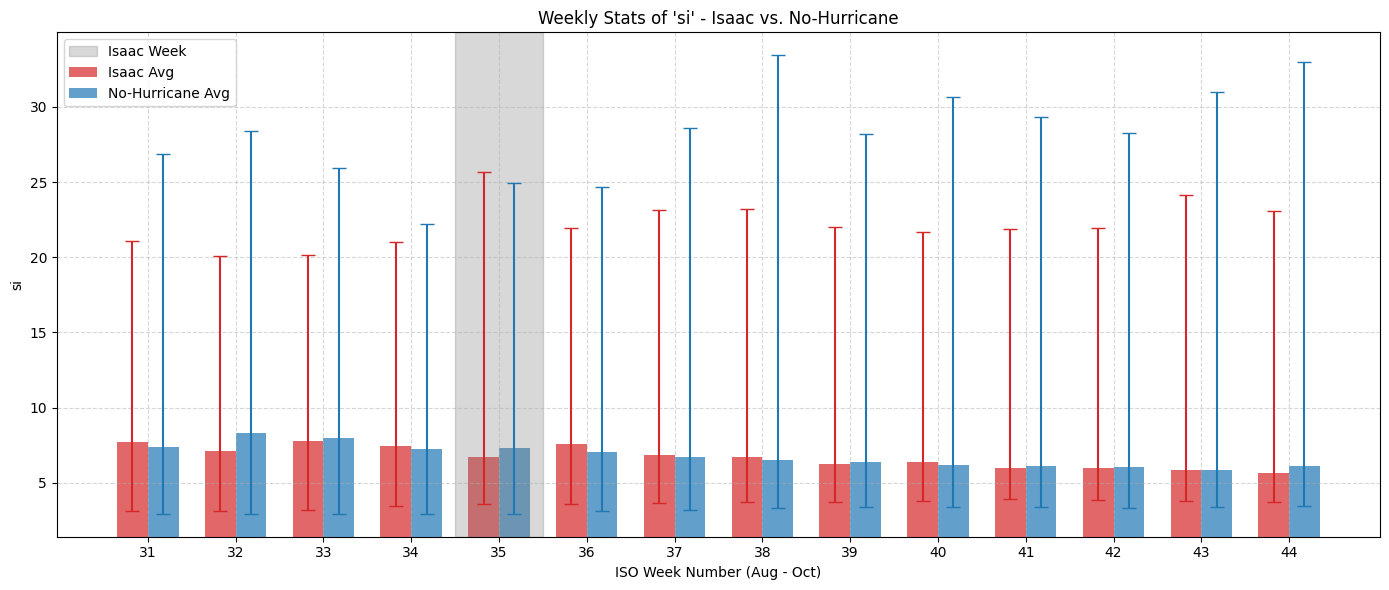

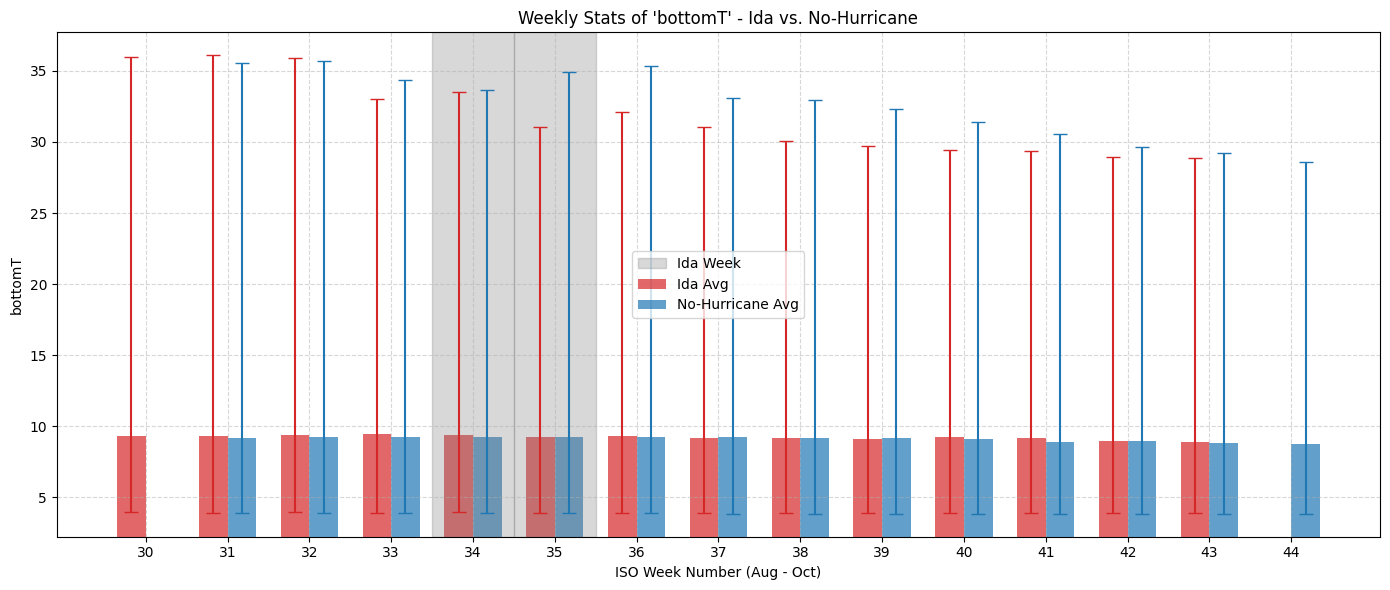

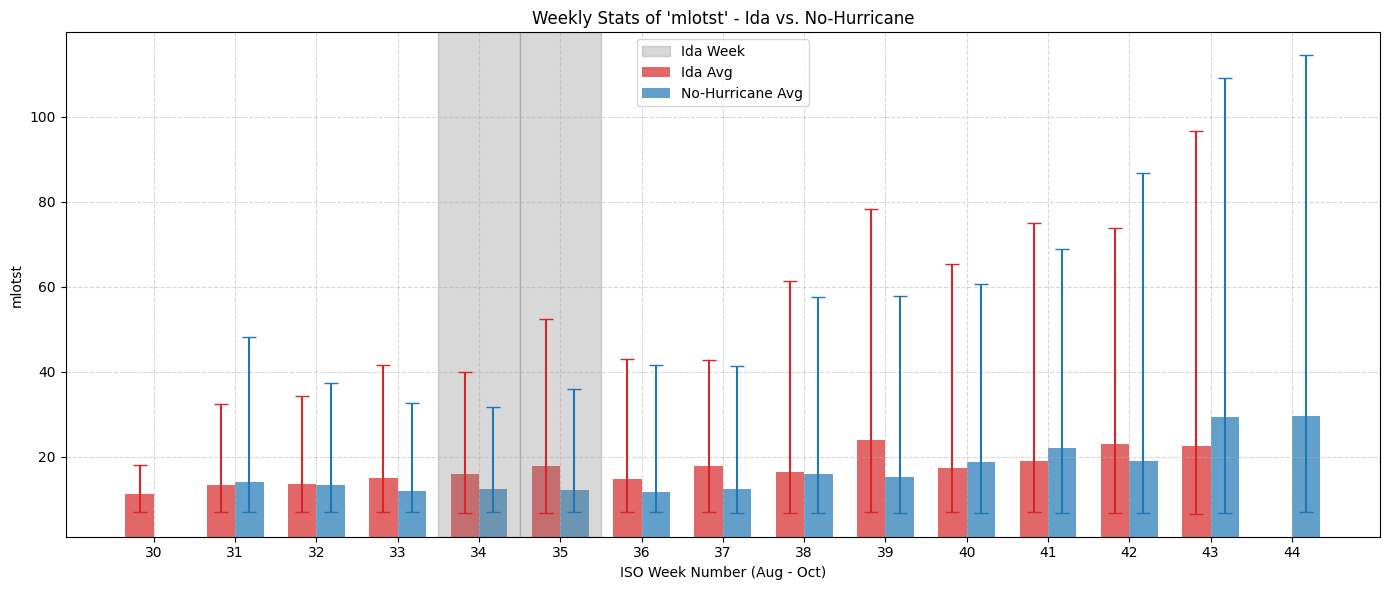

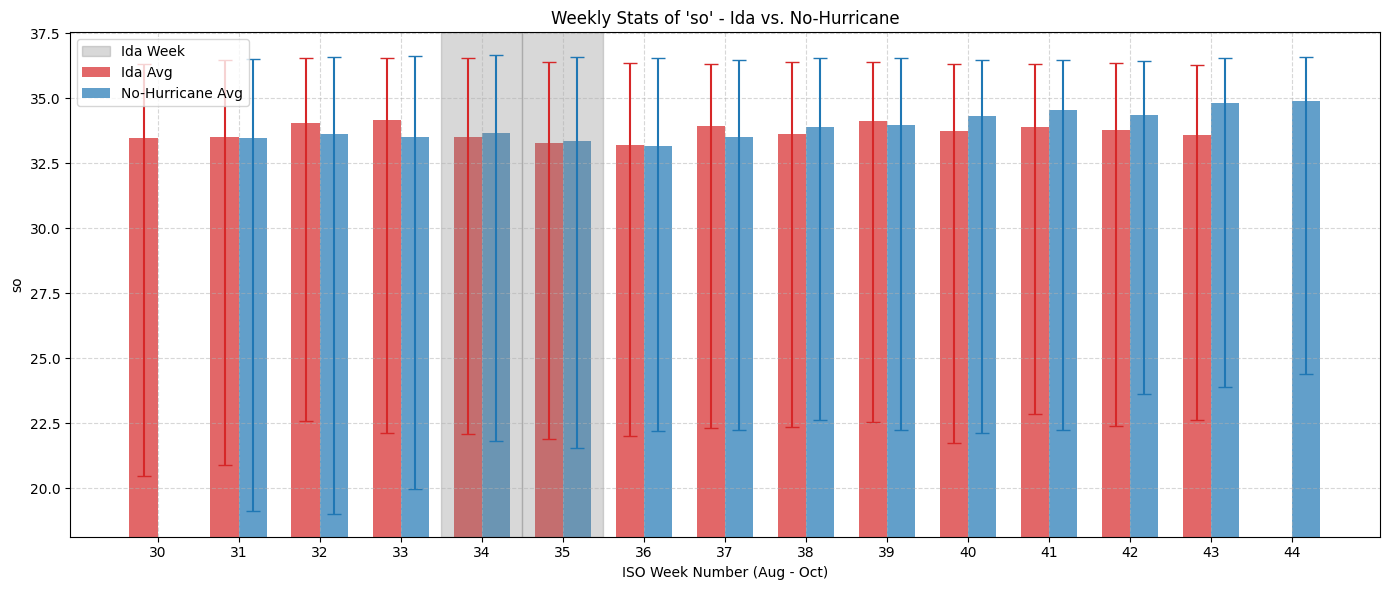

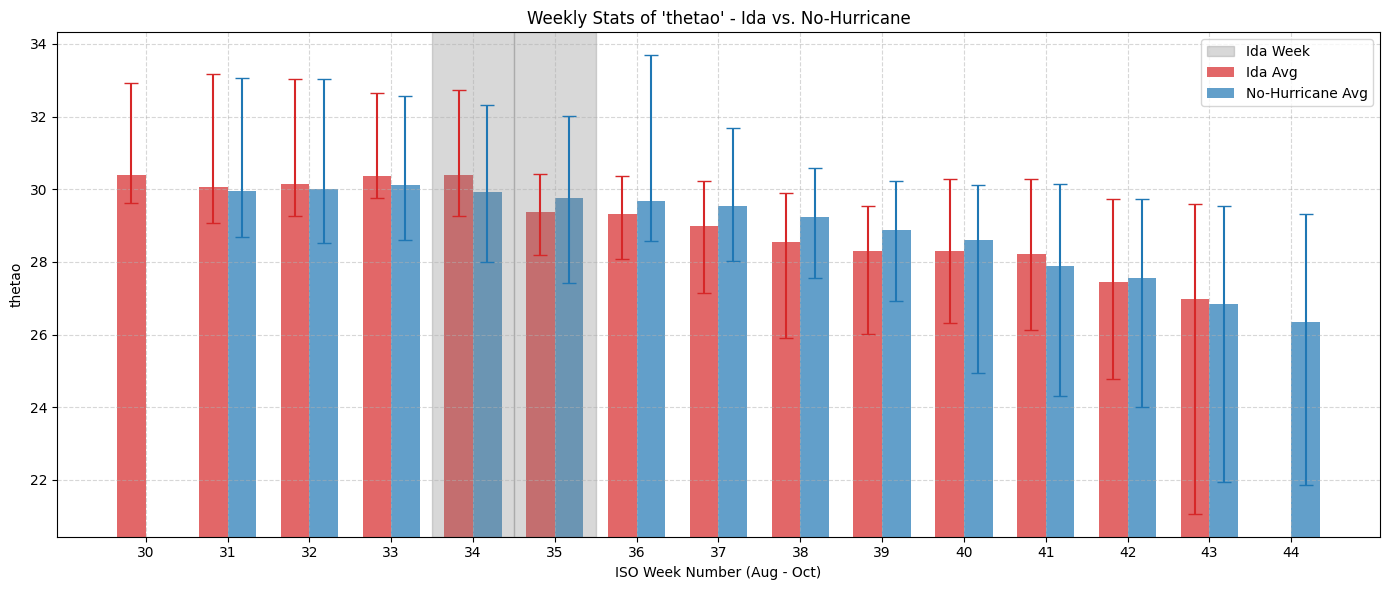

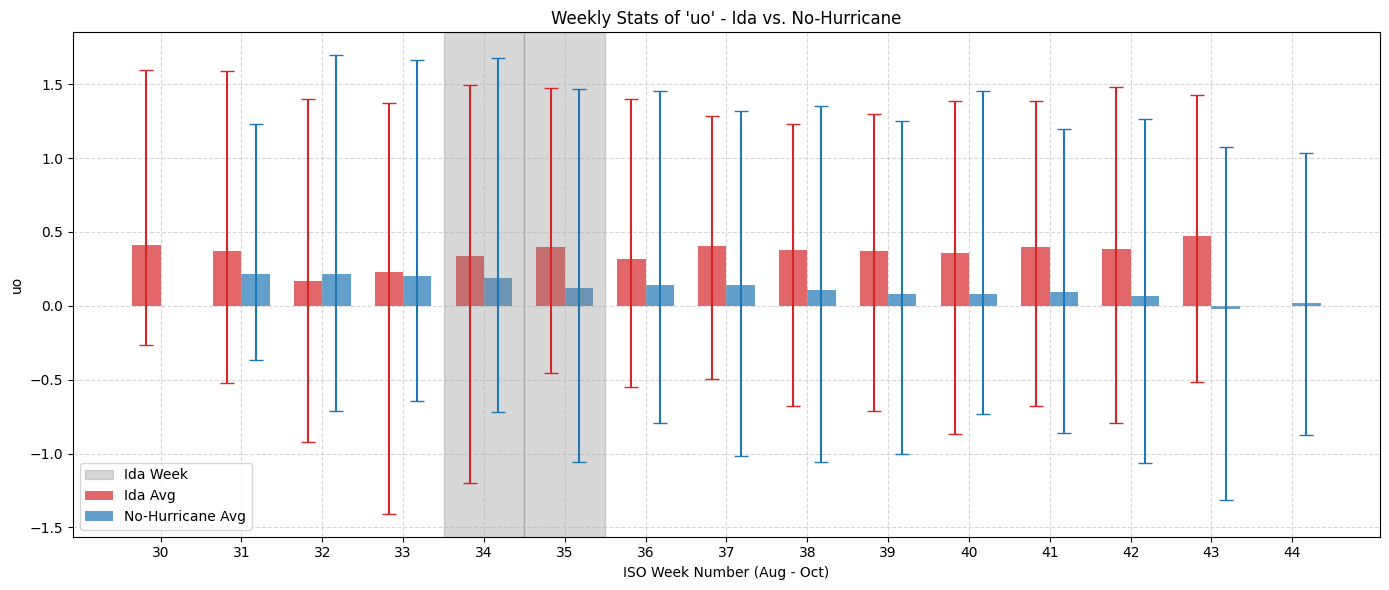

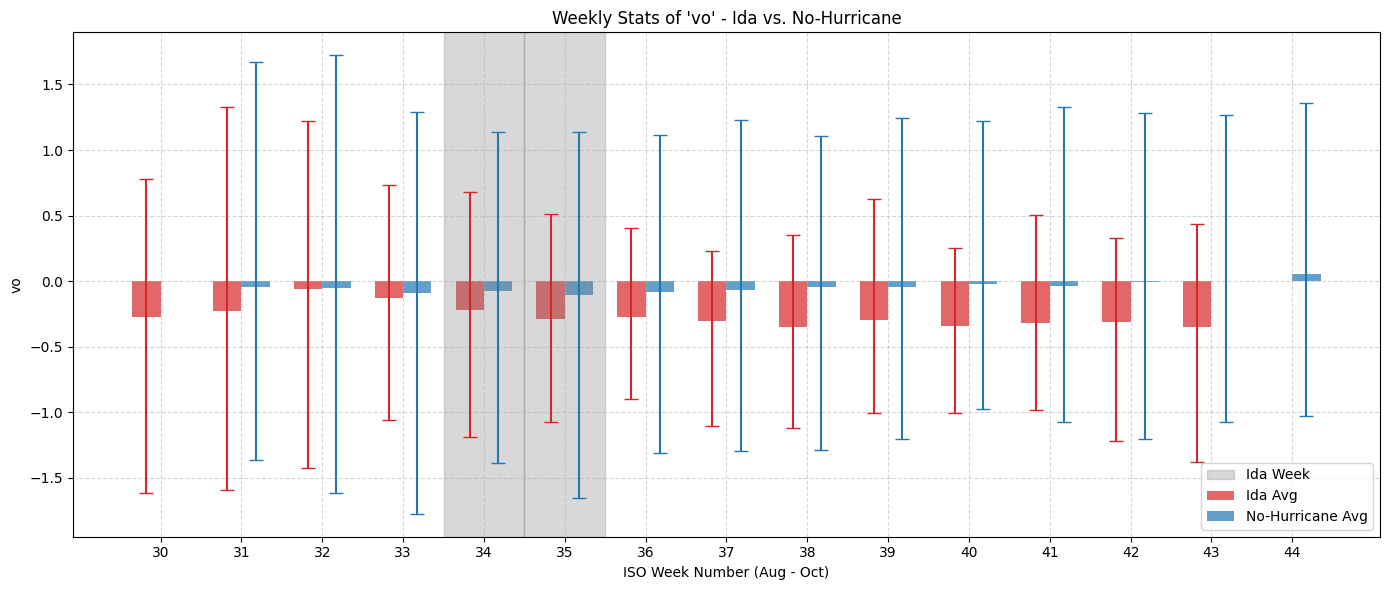

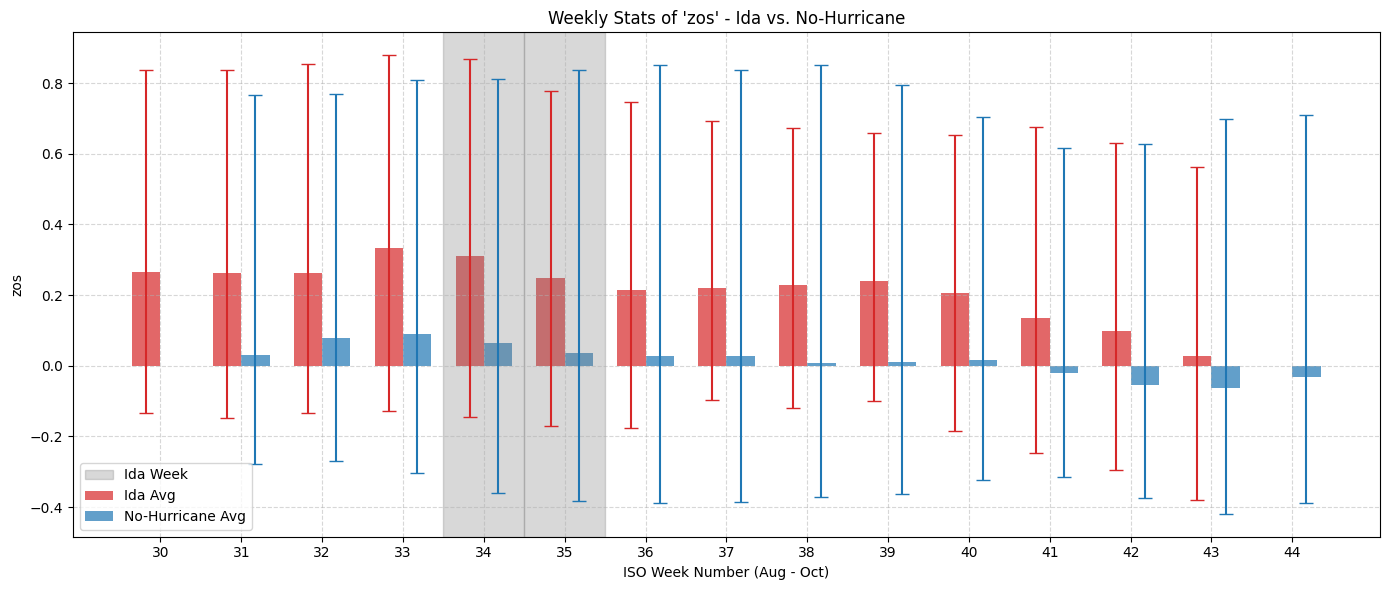

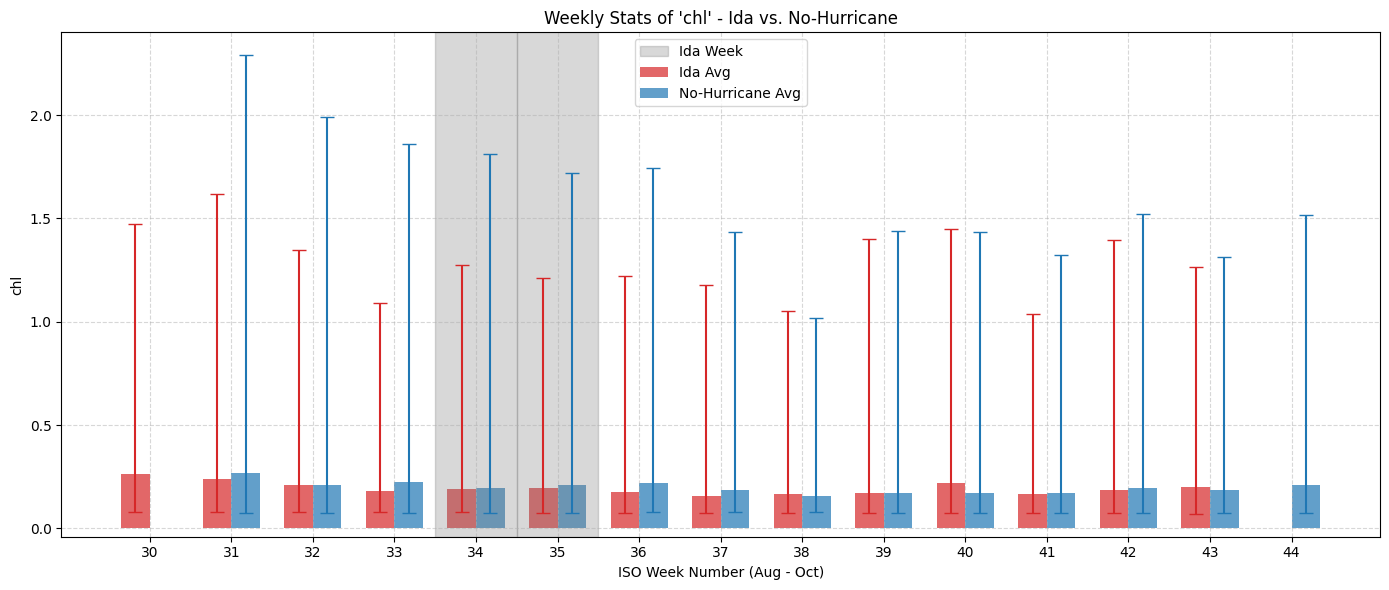

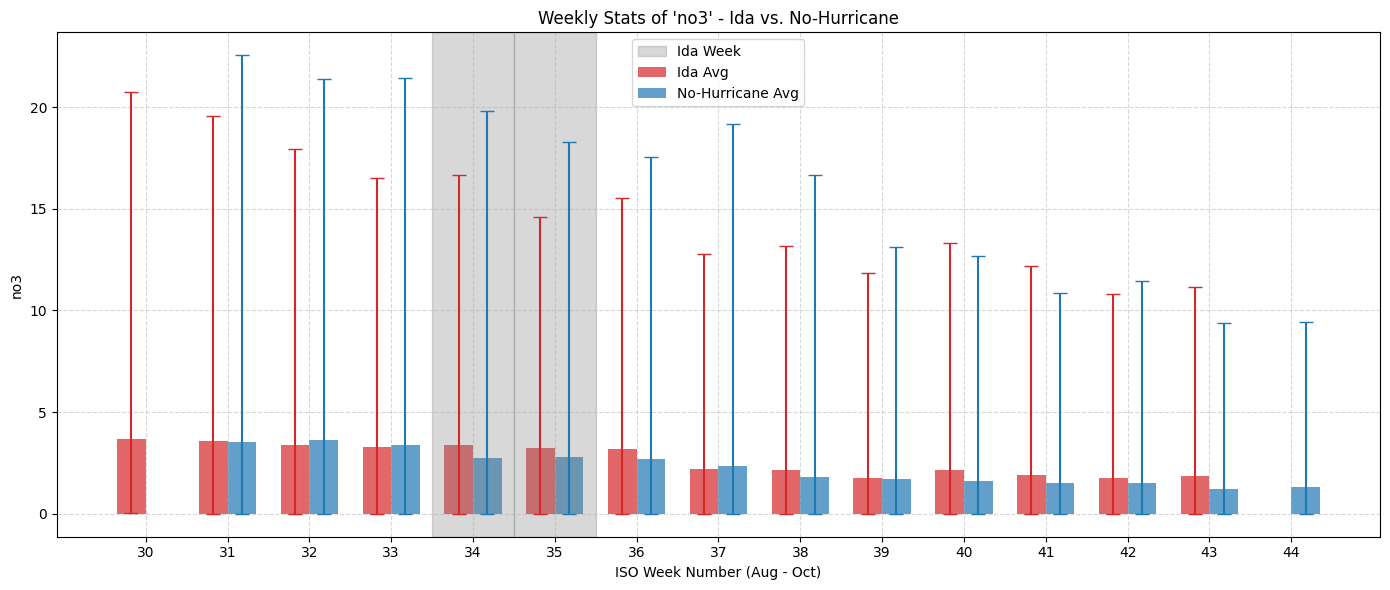

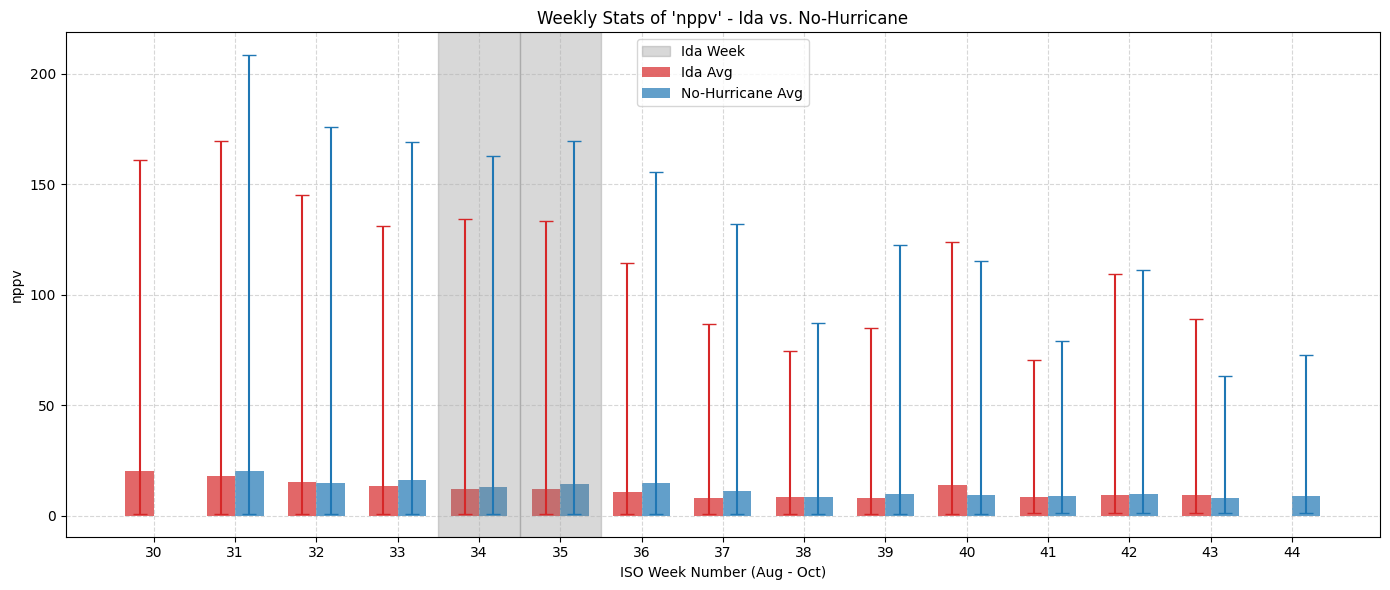

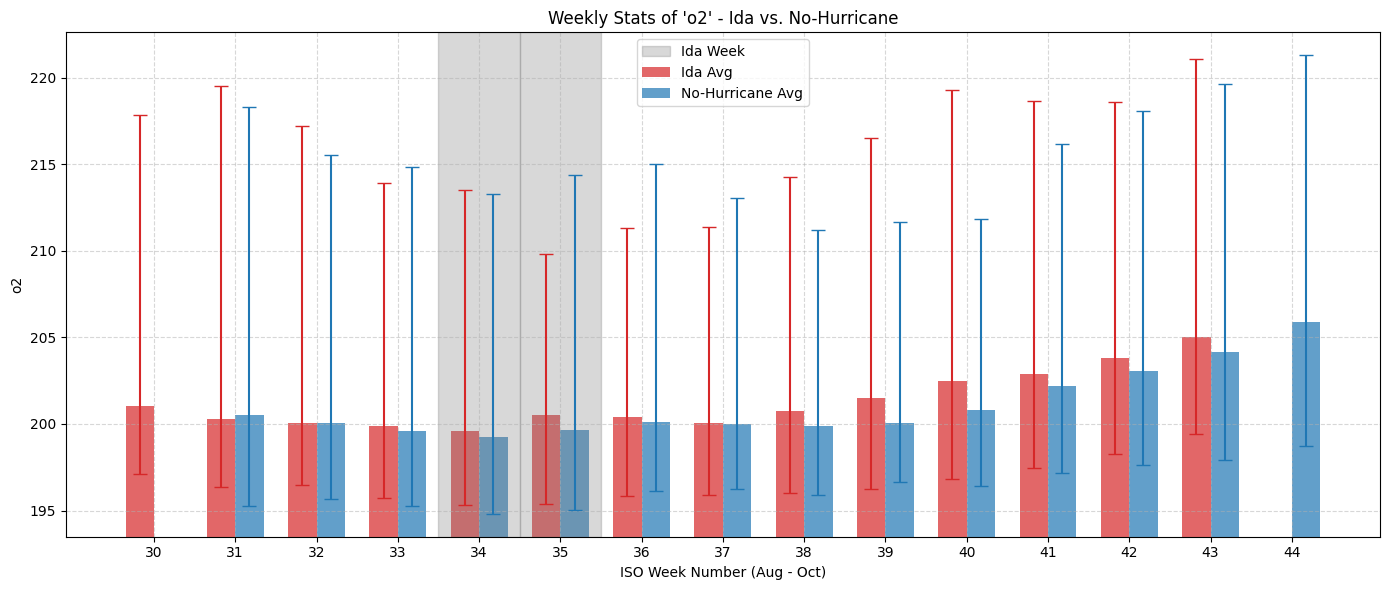

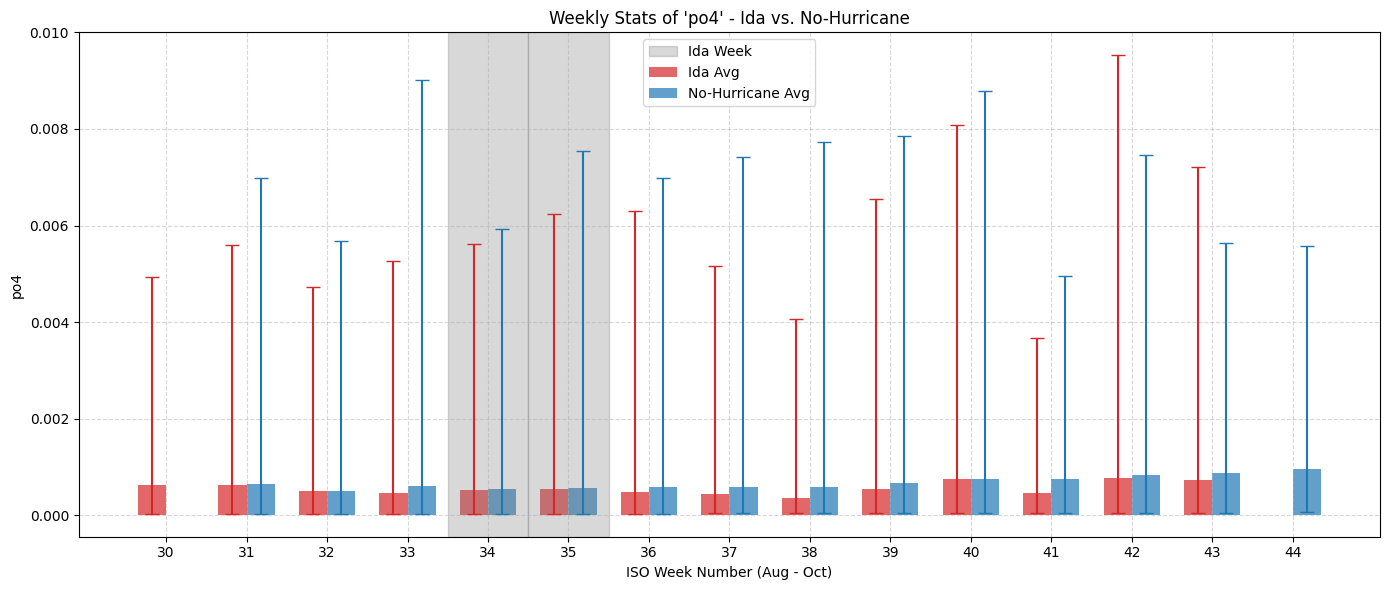

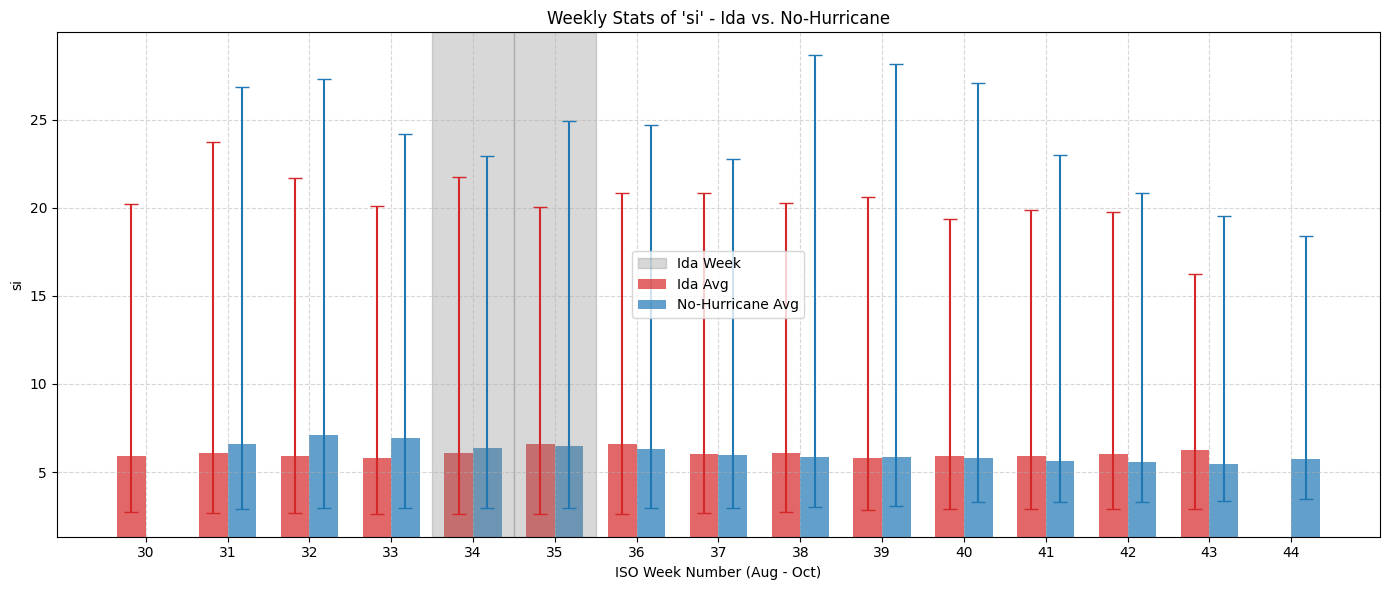

In [320]:
for hurricane in hurricane_names:
    latlon_points = get_latlon_within_radius(ds, hurricane_tracks, hurricane, radius_deg=0.6)
    ds_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=int(hurricane_tracks[hurricane]['year']))
    ds_no_hurricane = extract_ds_grouped_by_time(ds, latlon_points, years=no_hurricane_years)

    for var in ds.data_vars:
        if var not in ['siconc','sithick','vsi','usi']:
            plot_hurricane_vs_nohurricane(
                ds_hurricane,
                ds_no_hurricane,
                var_name=var,
                hurricane_meta=hurricane_tracks[hurricane],
                hurricane_name=hurricane)
